In [ ]:
import json
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [ ]:
PROJPATH = Path().resolve().parent
breakupdata = PROJPATH / "data/breakupdata/derived"
stationdata = PROJPATH / "data/weatherstations/ACIS/TDD/tdd_cumul_bystation"
outpath = PROJPATH / "data/breakupdata/working"

### Helper functions

In [ ]:
def datestr2dayssince(datestr, since='0301'):
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d').date()
    since_mth = int(since[:2])
    since_day = int(since[3:])
    since_date = dt.date(thedate.year, since_mth, since_day)
    return (thedate - since_date).days

In [ ]:
def dayssince2date(days, year, since='0301'):
    since_date = dt.datetime.strptime(f"{year}{since}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=days))

In [ ]:
datestr2dayssince('2020-04-15')

45

In [ ]:
dayssince2date(43, 2022)

datetime.date(2022, 4, 13)

### Load data

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup 

id                           siteID  year     breakup
0     7175         Koyukuk River at Bettles  2022  2022-05-05
1     7173          Kobuk River at Shungnak  2022  2022-05-20
2     7172       Buckland River at Buckland  2022  2022-05-21
3     7171  Yukon River at Mountain Village  2022  2022-05-10
4     7170          Yukon River at Marshall  2022  2022-05-15
...    ...                              ...   ...         ...
1490   213       Buckland River at Buckland  1988  1988-05-05
1491   212       Buckland River at Buckland  1987  1987-05-22
1492   211       Buckland River at Buckland  1986  1986-05-30
1493   210       Buckland River at Buckland  1984  1984-05-23
1494   209       Buckland River at Buckland  1983  1983-05-12

[1494 rows x 4 columns]

In [ ]:
climatologies = pd.read_csv(PROJPATH / "data/weatherstations/ACIS/TDD/all_cumul_clim1991_2020.csv", header=3, index_col=0)
climatologies

GULKANA_AIRPORT  TANANA_AIRPORT  KETCHIKAN_AIRPORT  \
d_since_march1                                                       
0                          0.00            0.00               4.30   
1                          0.00            0.00               8.65   
2                          0.00            0.00              13.33   
3                          0.00            0.00              15.84   
4                          0.00            0.00              18.42   
...                         ...             ...                ...   
117                     1089.80         1197.70            1656.02   
118                     1114.59         1225.56            1681.10   
119                     1139.42         1254.35            1706.48   
120                     1165.64         1283.85            1730.96   
121                     1191.74         1313.73            1755.63   

                COLLEGE_OBSERVATORY  AUKE_BAY  BETHEL_AIRPORT  \
d_since_march1                                                  
0                              0.00      0.10            0.00   
1                              0.00      0.24            0.00   
2                              0.00      0.24            0.00   
3                              0.00      0.24            0.00   
4                              0.00      0.24            0.00   
...                             ...       ...             ...   
117                         1312.75   1540.05          924.30   
118                         1341.58   1565.31          946.68   
119                         1370.45   1591.26          969.11   
120                         1399.64   1616.96          991.78   
121                         1430.76   1641.56         1014.66   

                ANCHORAGE_MERRILL_FIELD  SKAGWAY_AIRPORT    EAGLE  \
d_since_march1                                                      
0                                  0.00             0.00     0.00   
1                                  0.00             0.00     0.00   
2                                  0.00             0.00     0.00   
3                                  0.00             0.00     0.00   
4                                  0.00             0.00     0.00   
...                                 ...              ...      ...   
117                             1402.03          1532.79  1209.40   
118                             1429.66          1559.27  1237.86   
119                             1457.16          1584.69  1266.97   
120                             1485.86          1609.67  1295.51   
121                             1513.99          1634.59  1326.21   

                BIG_DELTA_AIRPORT  ...  \
d_since_march1                     ...   
0                            0.00  ...   
1                            0.00  ...   
2                            0.00  ...   
3                            0.00  ...   
4                            0.00  ...   
...                           ...  ...   
117                       1291.97  ...   
118                       1319.18  ...   
119                       1347.30  ...   
120                       1376.36  ...   
121                       1405.19  ...   

                ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT  YAKUTAT_AIRPORT  \
d_since_march1                                                                 
0                                                      0.00             0.00   
1                                                      0.00             0.00   
2                                                      0.00             0.00   
3                                                      0.00             0.00   
4                                                      0.00             0.00   
...                                                     ...              ...   
117                                                 1287.18          1120.21   
118                                                 1313.30          1141.43   
119           

In [ ]:
tdd = sorted(list(stationdata.glob("*.csv")))

In [ ]:
def retrieve_tdd(row, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march-offset][str(row.year)]
    except KeyError:
        return np.nan

def retrieve_tdd_anomaly(row, stationname, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march1-offset][str(row.year)] - climatologies[stationname].iloc[row.days_since_march1-offset]
    except KeyError:
        return np.nan
    
def retrieve_tdd_anomaly_fixed(row, stationname, stationDF, datestring):
    """Datestring is something like 04-15"""
    days_since_march1 = datestr2dayssince(f"{str(row.year)}-{datestring}")
    try:
        return stationDF.iloc[days_since_march1][str(row.year)] - climatologies[stationname].iloc[days_since_march1]
    except KeyError:
        return np.nan

### Prototyping: one location only

In [ ]:
location = "Yukon River at Eagle"
breakup = breakup[breakup.siteID == location].sort_values(by='year').reset_index(drop=True)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup

id                siteID  year     breakup  days_since_march1
0   5330  Yukon River at Eagle  1980  1980-05-03                 63
1   5331  Yukon River at Eagle  1981  1981-05-07                 67
2   5332  Yukon River at Eagle  1982  1982-05-14                 74
3   5333  Yukon River at Eagle  1983  1983-05-02                 62
4   5334  Yukon River at Eagle  1984  1984-05-09                 69
5   5335  Yukon River at Eagle  1985  1985-05-16                 76
6   5336  Yukon River at Eagle  1986  1986-05-11                 71
7   5337  Yukon River at Eagle  1987  1987-05-09                 69
8   5338  Yukon River at Eagle  1988  1988-05-02                 62
9   5339  Yukon River at Eagle  1989  1989-04-29                 59
10  5340  Yukon River at Eagle  1990  1990-04-25                 55
11  5341  Yukon River at Eagle  1991  1991-04-28                 58
12  5342  Yukon River at Eagle  1992  1992-05-12                 72
13  5343  Yukon River at Eagle  1993  1993-04-29                 59
14  5344  Yukon River at Eagle  1994  1994-04-29                 59
15  5345  Yukon River at Eagle  1995  1995-04-29                 59
16  5346  Yukon River at Eagle  1996  1996-05-08                 68
17  5347  Yukon River at Eagle  1997  1997-05-04                 64
18  5348  Yukon River at Eagle  1998  1998-04-29                 59
19  5349  Yukon River at Eagle  1999  1999-05-11                 71
20  5350  Yukon River at Eagle  2000  2000-05-06                 66
21  5351  Yukon River at Eagle  2001  2001-05-12                 72
22  5352  Yukon River at Eagle  2002  2002-05-18                 78
23  6208  Yukon River at Eagle  2003  2003-04-27                 57
24  6215  Yukon River at Eagle  2004  2004-05-03                 63
25  6262  Yukon River at Eagle  2005  2005-04-28                 58
26  6291  Yukon River at Eagle  2006  2006-05-08                 68
27  6334  Yukon River at Eagle  2007  2007-04-30                 60
28  6385  Yukon River at Eagle  2008  2008-05-03                 63
29  6403  Yukon River at Eagle  2009  2009-05-03                 63
30  6429  Yukon River at Eagle  2010  2010-04-29                 59
31  6465  Yukon River at Eagle  2011  2011-05-07                 67
32  6489  Yukon River at Eagle  2012  2012-04-29                 59
33  6543  Yukon River at Eagle  2013  2013-05-17                 77
34  6591  Yukon River at Eagle  2014  2014-05-01                 61
35  6672  Yukon River at Eagle  2015  2015-05-06                 66
36  6729  Yukon River at Eagle  2016  2016-04-26                 56
37  6797  Yukon River at Eagle  2017  2017-05-04                 64
38  6888  Yukon River at Eagle  2018  2018-05-08                 68
39  6942  Yukon River at Eagle  2019  2019-05-01                 61
40  7001  Yukon River at Eagle  2020  2020-05-05                 65
41  7067  Yukon River at Eagle  2021  2021-05-08                 68
42  7135  Yukon River at Eagle  2022  2022-05-07                 67

In [ ]:
teststationDF = pd.read_csv(tdd[13], skiprows=4, index_col=0)
teststationDF

1980    1981    1983    1984    1985    1986     1987  \
d_since_march1                                                            
0                  0.0     0.0     0.0     0.0     0.0     0.0     0.00   
1                  0.0     0.0     0.0     0.0     0.0     0.0     0.00   
2                  0.0     0.0     0.0     0.0     0.0     0.0     0.00   
3                  0.0     0.0     0.0     0.0     0.0     0.0     0.00   
4                  0.0     0.0     0.0     0.0     0.0     0.0     0.00   
...                ...     ...     ...     ...     ...     ...      ...   
117             1288.0  1247.0  1154.5  1196.5   953.0  1013.5  1073.91   
118             1321.0  1273.0  1193.5  1226.0   975.5  1038.5  1097.41   
119             1358.0  1291.0  1231.5  1255.0   993.5  1069.0  1127.41   
120             1392.5  1308.5  1265.5  1277.5  1022.0  1101.5  1157.91   
121             1425.0  1327.5  1300.0  1305.0  1055.0  1135.0  1192.41   

                  1988     1989    1990  ...    2012    2013    2014    2015  \
d_since_march1                           ...                                   
0                  0.0     0.00     0.0  ...     0.0     0.0     0.0     0.0   
1                  0.0     0.00     0.0  ...     0.0     0.0     0.0     0.0   
2                  1.0     0.00     0.0  ...     0.0     0.0     0.0     0.0   
3                  1.0     0.00     0.0  ...     0.0     0.0     0.0     0.0   
4                  1.0     0.00     0.0  ...     0.0     0.0     0.0     0.0   
...                ...      ...     ...  ...     ...     ...     ...     ...   
117             1251.5  1243.01  1277.5  ...  1316.0  1084.5  1233.0  1440.0   
118             1281.0  1270.51  1313.5  ...  1347.0  1121.5  1252.0  1471.0   
119             1305.0  1299.51  1347.0  ...  1376.0  1166.5  1281.0  1492.0   
120             1335.0  1331.01  1377.0  ...  1402.5  1203.5  1307.0  1519.0   
121             1366.5  1364.01  1407.0  ...  1432.0  1233.0  1341.5  1547.0   

                  2016    2017     2018    2019    2020     2021  
d_since_march1                                                    
0                  0.0     0.0     0.00     0.0     0.0     0.00  
1                  0.0     0.0     0.00     0.0     0.0     0.00  
2                  0.0     0.0     0.00     0.0     0.0     0.00  
3                  0.0     0.0     0.00     0.0     0.0     0.00  
4                  0.0     0.0     0.00     0.0     0.0     0.00  
...                ...     ...      ...     ...     ...      ...  
117             1415.5  1257.0  1163.84  1435.0  1324.6  1303.38  
118             1451.0  1282.5  1189.84  1461.0  1348.6  1337.88  
119             1477.5  1310.0  1214.34  1490.0  1372.6  1367.38  
120             1507.0  1339.5  1242.34  1519.5  1397.6  1400.88  
121             1543.5  1375.5  1270.34  1560.0  1419.1  1427.38  

[122 rows x 40 columns]

In [ ]:
breakup_anomaly = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup[stationname] = breakup.apply(
        lambda row: retrieve_tdd(row, teststationDF), axis=1)

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_tdd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
breakup_anomaly.columns

Index(['id', 'siteID', 'year', 'breakup', 'days_since_march1', 'ALYESKA',
       'ANCHORAGE_MERRILL_FIELD',
       'ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT', 'AUKE_BAY',
       'BARROW_AIRPORT', 'BETHEL_AIRPORT', 'BETTLES_AIRPORT',
       'BIG_DELTA_AIRPORT', 'CHICKEN', 'COLD_BAY_AIRPORT',
       'COLLEGE_OBSERVATORY', 'CORDOVA_AIRPORT', 'DUTCH_HARBOR', 'EAGLE',
       'FAIRBANKS_INTL_AP', 'GULKANA_AIRPORT', 'HAINES_AIRPORT',
       'HOMER_AIRPORT', 'ILIAMNA_AIRPORT', 'JUNEAU_AIRPORT', 'KENAI_AIRPORT',
       'KETCHIKAN_AIRPORT', 'KING_SALMON_AIRPORT', 'KODIAK_AIRPORT',
       'KOTZEBUE_AIRPORT', 'MCGRATH_AP', 'MCKINLEY_PARK', 'NENANA_MUN_AP',
       'NOME_AIRPORT', 'NORTHWAY_AIRPORT', 'NORTH_POLE',
       'SAINT_PAUL_ISLAND_AIRPORT', 'SITKA_AIRPORT', 'SKAGWAY_AIRPORT',
       'TALKEETNA_AIRPORT', 'TANANA_AIRPORT', 'YAKUTAT_AIRPORT'],
      dtype='object')

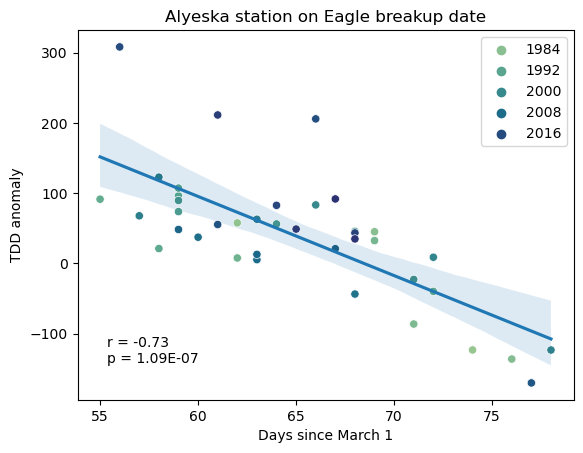

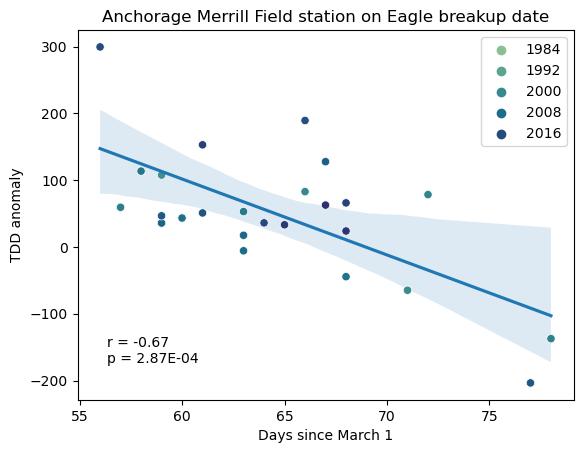

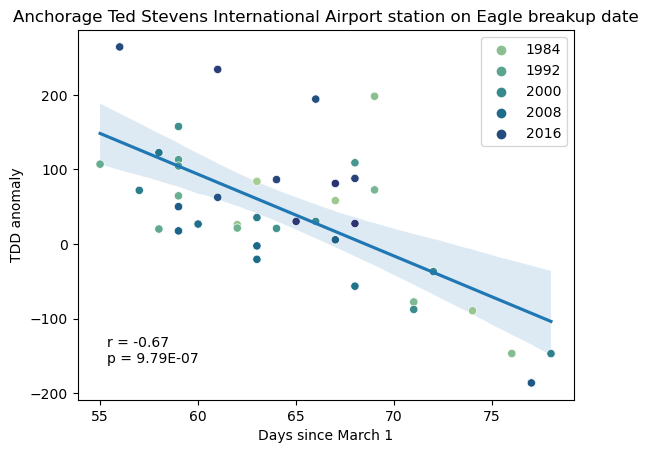

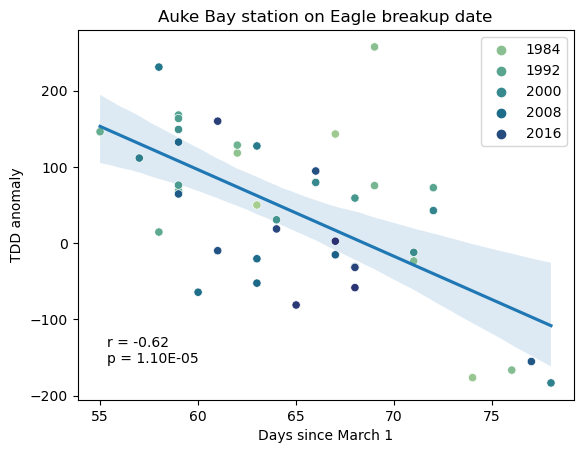

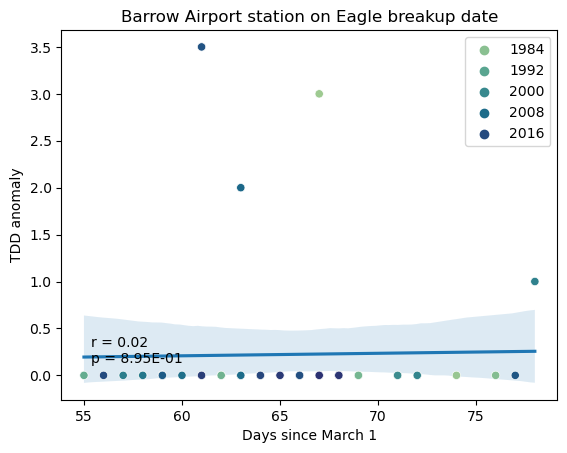

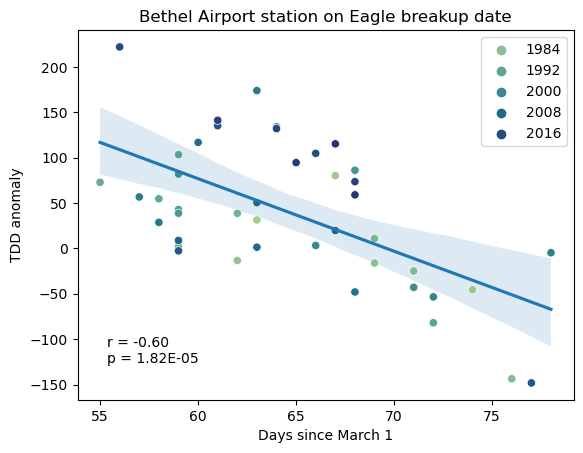

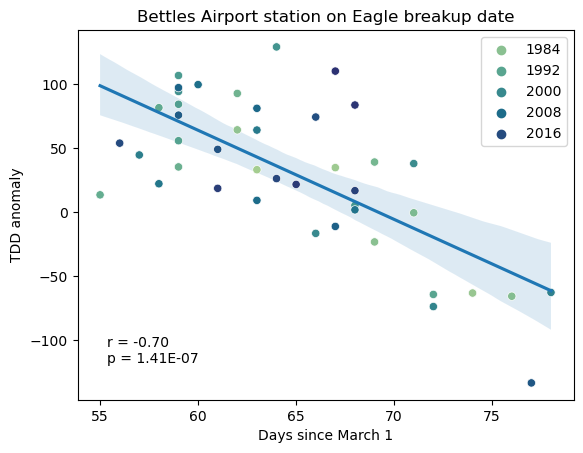

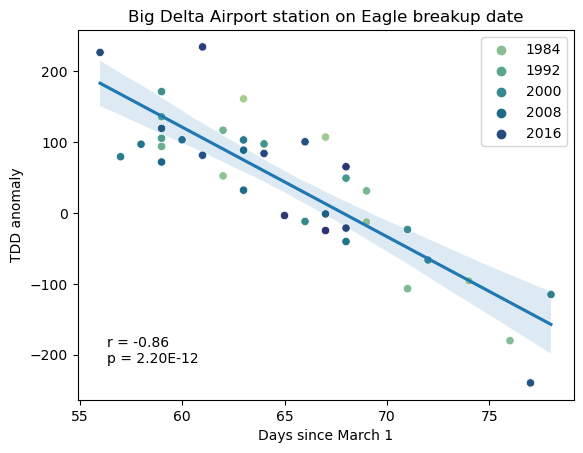

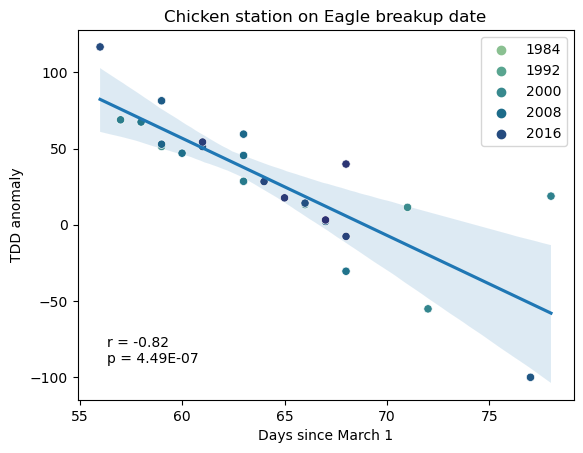

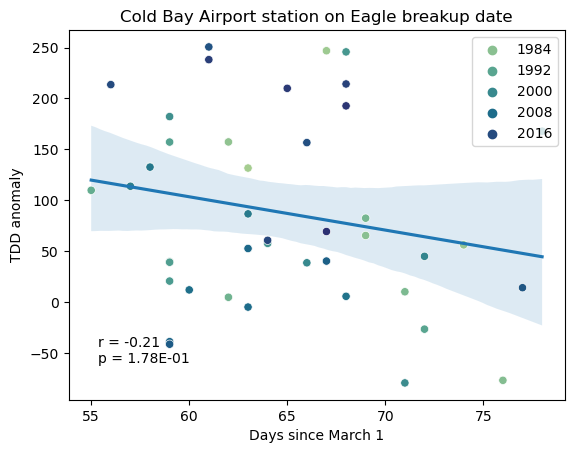

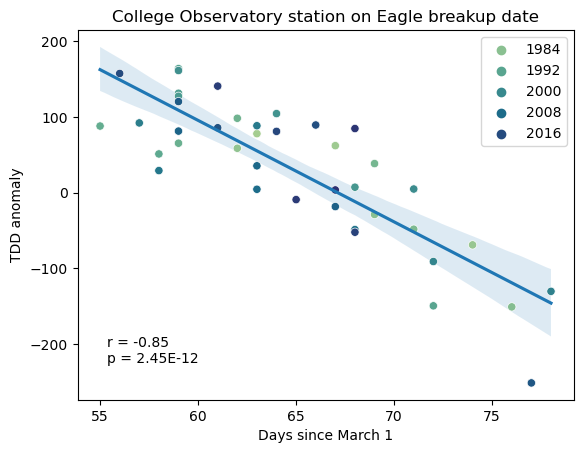

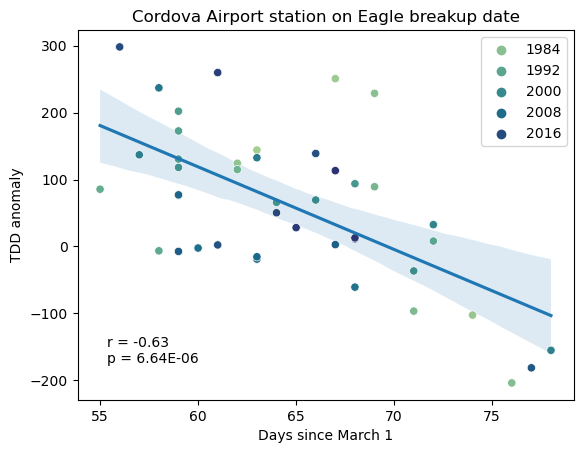

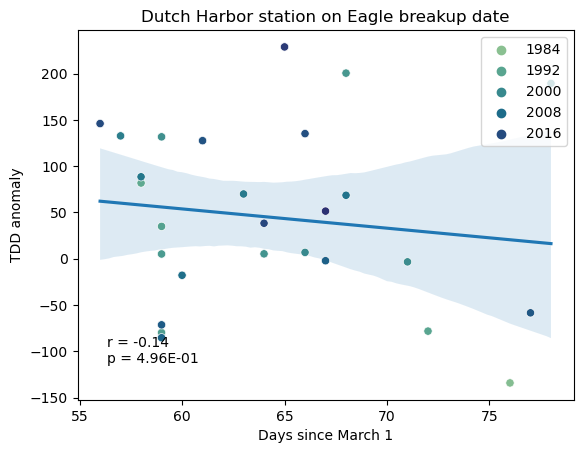

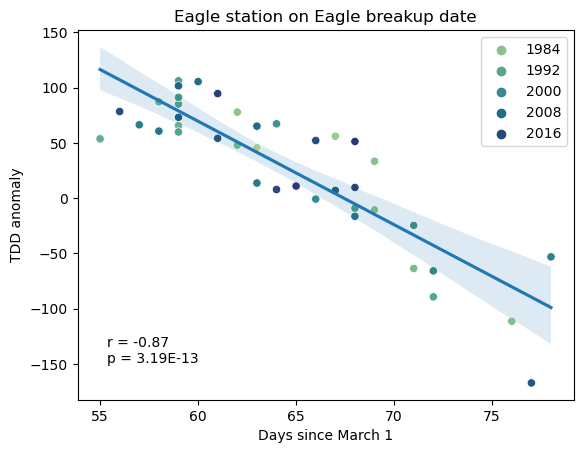

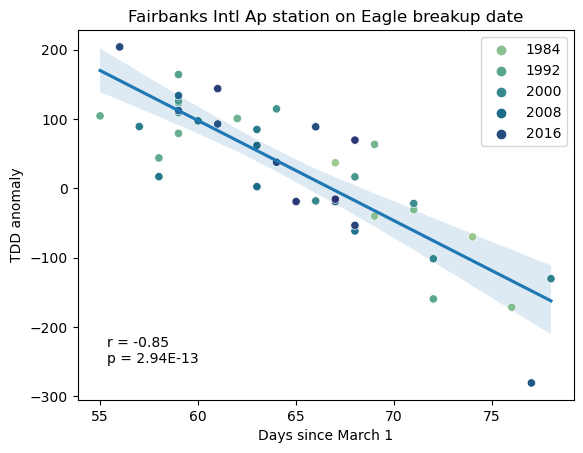

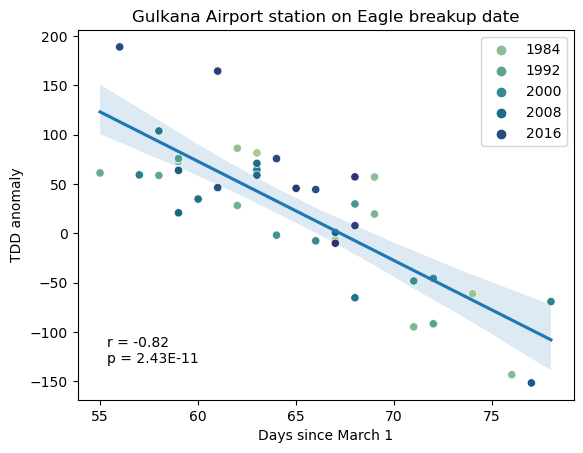

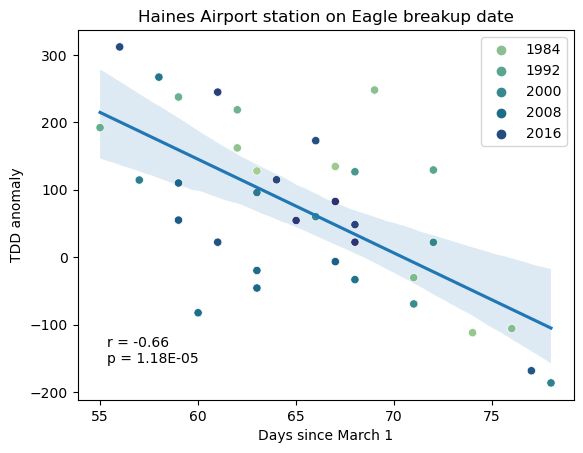

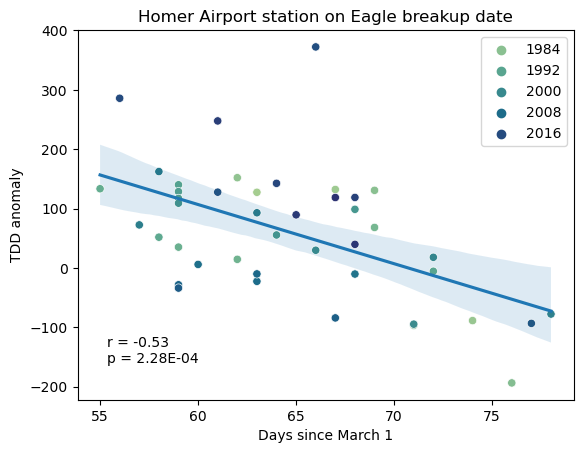

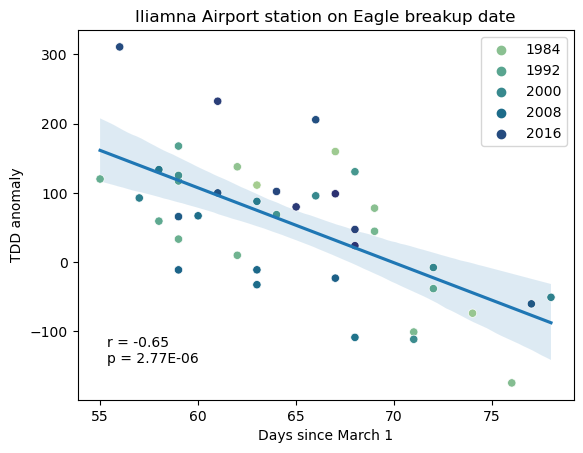

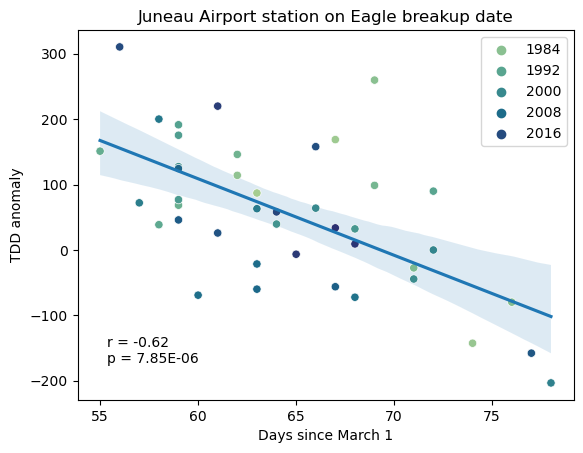

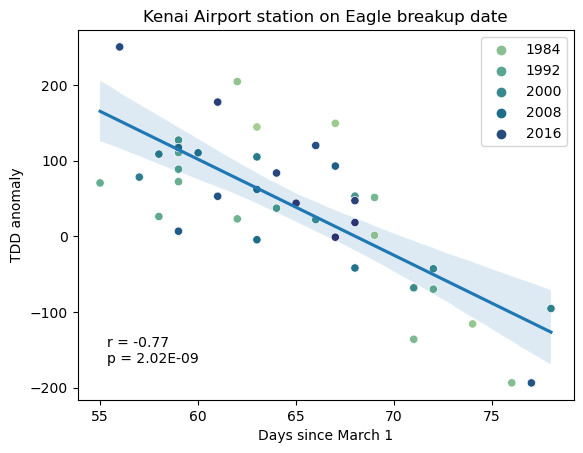

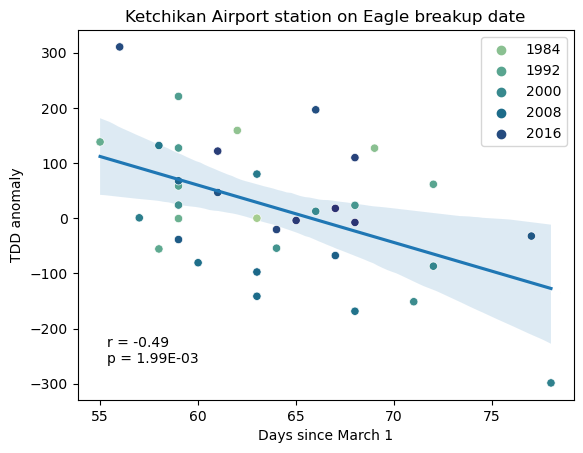

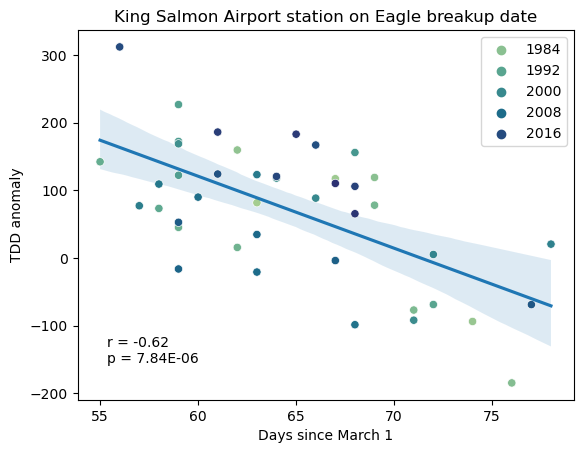

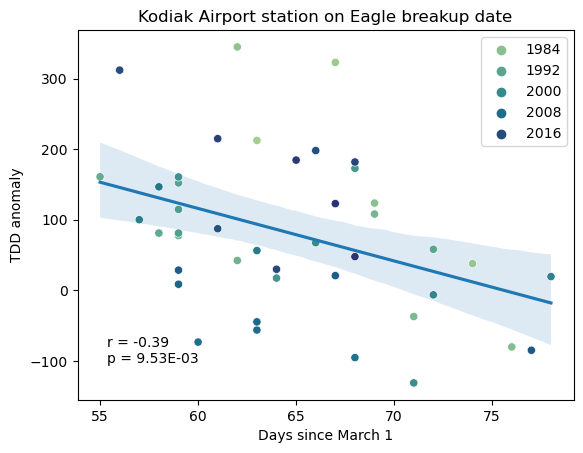

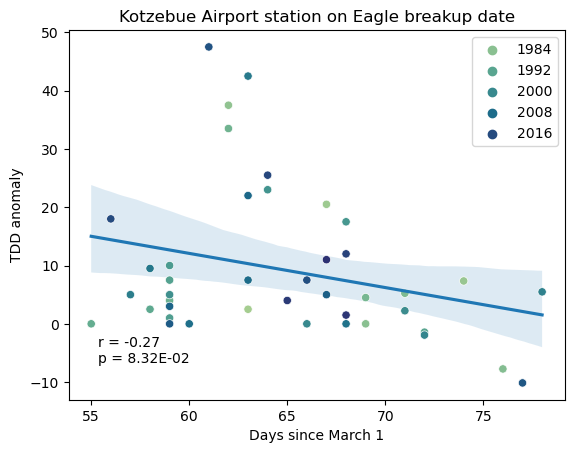

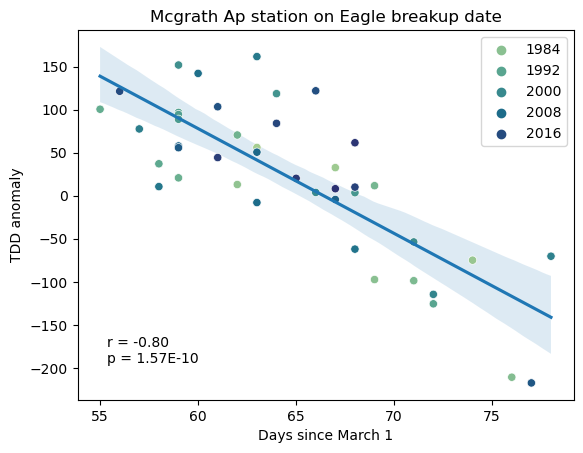

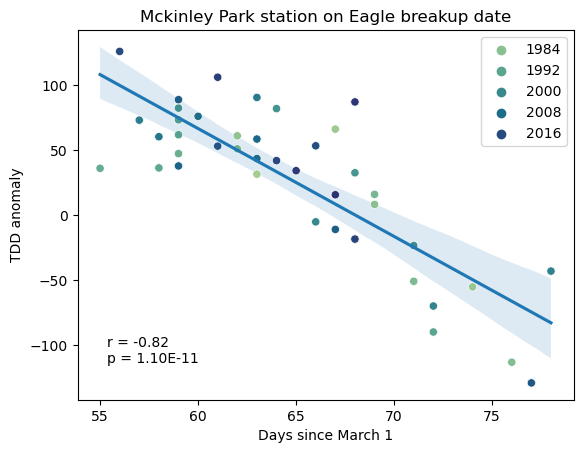

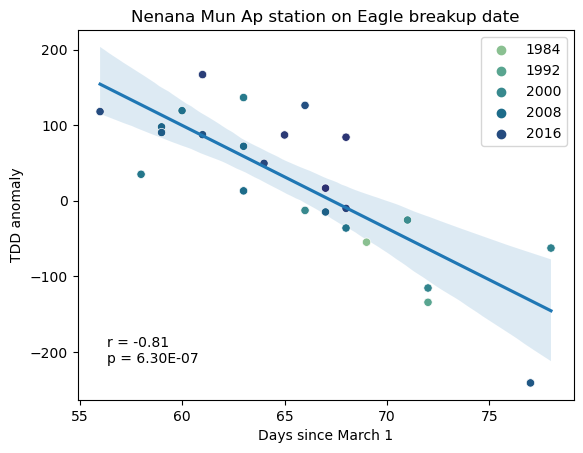

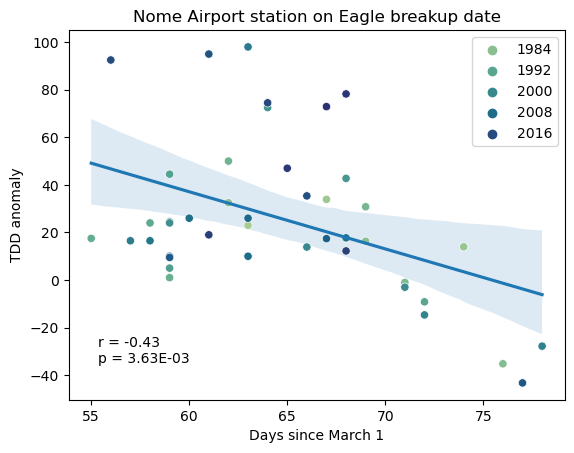

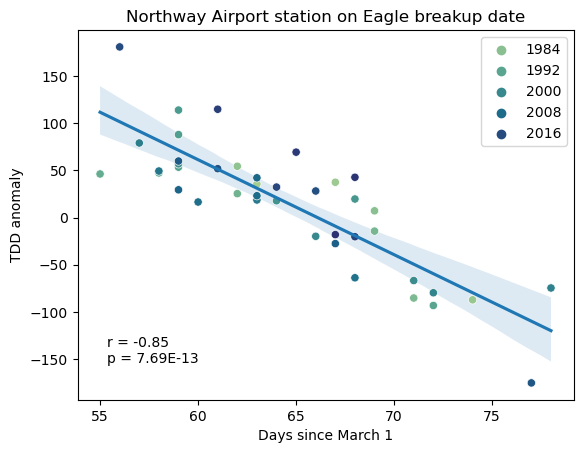

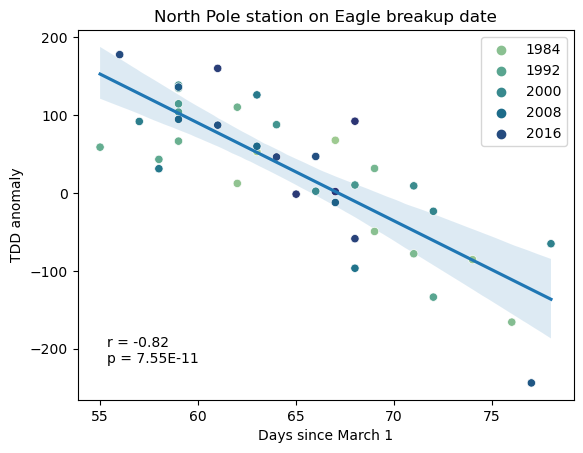

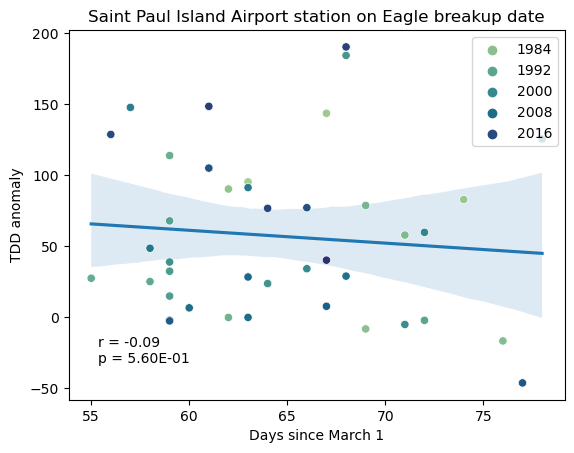

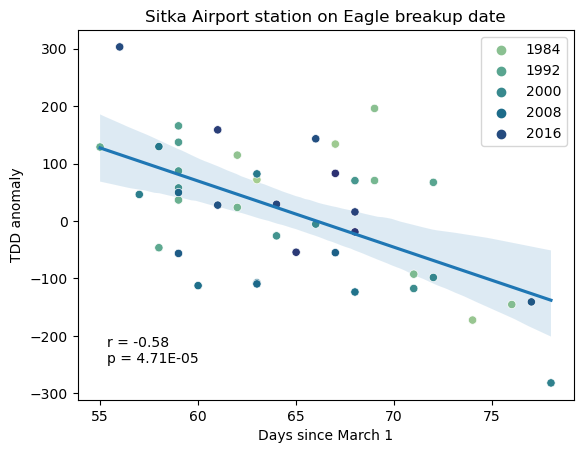

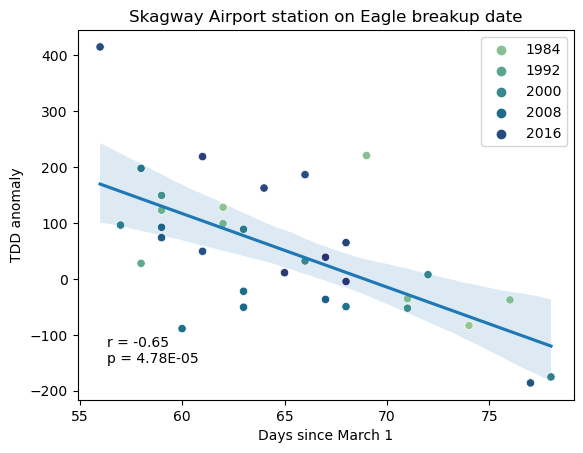

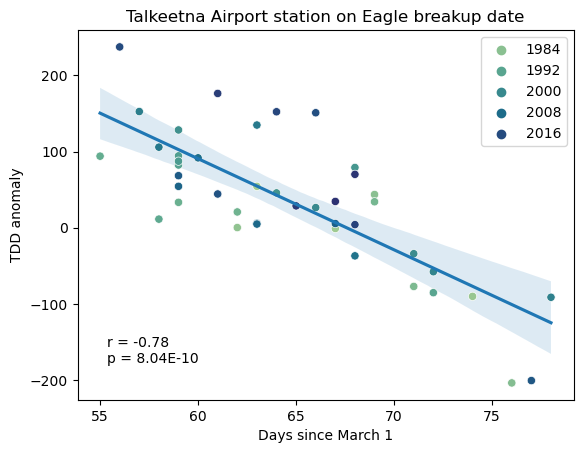

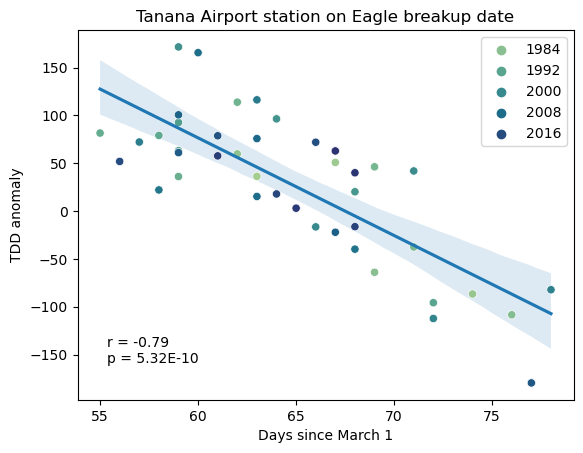

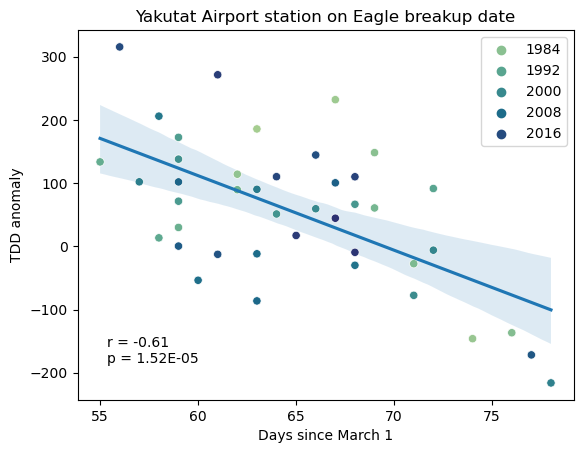

In [ ]:
for stationname in breakup_anomaly.columns[5:]:
    sb.regplot(data=breakup_anomaly, x='days_since_march1', y=stationname, scatter=False)
    ax = sb.scatterplot(data=breakup_anomaly, x='days_since_march1', y=stationname, hue='year', palette="crest")
    ax.set_title(f"{stationname.replace('_', ' ').title()} station on Eagle breakup date")
    ax.set_ylabel("TDD anomaly")
    ax.set_xlabel("Days since March 1")
    plt.legend(loc='upper right')
    result = breakup_anomaly[stationname].corr(breakup_anomaly['days_since_march1'],
                method=lambda x, y: pearsonr(x, y))
    ax.text(0.06, 0.1, f'r = {result.statistic:.2f}\np = {result.pvalue:.2E}', transform=ax.transAxes)
    plt.show()

In [ ]:
# breakup_only = breakup_anomaly[breakup_anomaly.columns[4:]]
breakup_only = breakup[breakup.columns[4:]]
breakup_standardized = ((breakup_only - breakup_only.mean())/breakup_only.std())
breakup_standardized

days_since_march1   ALYESKA  ANCHORAGE_MERRILL_FIELD  \
0           -0.288825       NaN                      NaN   
1            0.391694       NaN                      NaN   
2            1.582603 -0.896403                      NaN   
3           -0.458955 -0.292036                      NaN   
4            0.731954  0.758274                      NaN   
5            1.922863 -0.643614                      NaN   
6            1.072214 -0.979792                      NaN   
7            0.731954  0.551685                      NaN   
8           -0.458955 -1.111183                      NaN   
9           -0.969344       NaN                      NaN   
10          -1.649864 -0.808099                      NaN   
11          -1.139474 -1.515678                      NaN   
12           1.242343  0.009246                      NaN   
13          -0.969344 -0.136398                      NaN   
14          -0.969344  0.043814                      NaN   
15          -0.969344 -0.505014                      NaN   
16           0.561824  0.563317                      NaN   
17          -0.118695  0.019239                      NaN   
18          -0.969344 -0.246164                -0.268502   
19           1.072214  0.060197                -0.315425   
20           0.221564  0.813812                 0.629740   
21           1.242343  0.805620                 1.832044   
22           2.263123  0.043814                 0.375015   
23          -1.309604 -0.906396                -1.253887   
24          -0.288825 -0.038101                -0.315425   
25          -1.139474  0.150303                -0.367040   
26           0.561824 -0.898205                -0.684106   
27          -0.799215 -0.947354                -0.952238   
28          -0.288825 -0.980120                -1.102660   
29          -0.288825 -0.857248                -0.791359   
30          -0.969344 -0.922779                -1.231230   
31           0.391694 -0.026469                 1.434136   
32          -0.969344       NaN                -1.086304   
33           2.092993 -0.963737                -0.757843   
34          -0.629085 -0.488632                -0.684106   
35           0.221564  2.820721                 2.057543   
36          -1.479734  2.878061                 1.796114   
37          -0.118695  0.453387                -0.362348   
38           0.561824  0.527110                 0.797323   
39          -0.629085  2.067106                 0.683366   
40           0.051435  0.076580                -0.228282   
41           0.561824  0.387855                 0.232771   
42           0.391694  1.133279                 0.562707   

    ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT  AUKE_BAY  BARROW_AIRPORT  \
0                                      0.229918 -0.260314       -0.291347   
1                                      0.562296  1.516027        3.664840   
2                                     -0.060029 -0.850618       -0.291347   
3                                     -0.753072  0.373309       -0.291347   
4                                      2.924302  3.233467       -0.291347   
5                                     -0.413622 -0.313549       -0.291347   
6                                     -0.562132  0.325976       -0.291347   
7                                      1.149262  1.085191       -0.291347   
8                                     -0.816719  0.495006       -0.291347   
9                                     -0.689425 -0.701773       -0.291347   
10                                    -0.703569 -0.416477       -0.291347   
11                                    -1.481475 -1.493920       -0.291347   
12                                     0.244062  1.663573       -0.291347   
13                                    -0.081244  0.471398       -0.291347   
14                                    -0.003454  0.418636       -0.291347   
15                                    -0.123676 -0.614544       -0.291347   
16                                     1.460424  0.701

In [ ]:
breakup_only.std().to_frame().T

days_since_march1    ALYESKA  ANCHORAGE_MERRILL_FIELD  \
0           5.877864  61.039128                74.590142   

   ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT   AUKE_BAY  BARROW_AIRPORT  \
0                                    70.702628  84.719093        0.758306   

   BETHEL_AIRPORT  BETTLES_AIRPORT  BIG_DELTA_AIRPORT    CHICKEN  ...  \
0       60.167023        37.065456           53.29605  30.029919  ...   

   NENANA_MUN_AP  NOME_AIRPORT  NORTHWAY_AIRPORT  NORTH_POLE  \
0       55.29388     26.908735         34.264246   51.789114   

   SAINT_PAUL_ISLAND_AIRPORT  SITKA_AIRPORT  SKAGWAY_AIRPORT  \
0                  57.568753      96.032168        94.897596   

   TALKEETNA_AIRPORT  TANANA_AIRPORT  YAKUTAT_AIRPORT  
0          54.588017       44.266324        89.253751  

[1 rows x 38 columns]

In [ ]:
breakup_standardized[breakup_standardized.columns[1:]].corrwith(breakup_standardized['days_since_march1'],
                method=lambda x, y: pearsonr(x, y)[1])

ALYESKA                                        0.950062
ANCHORAGE_MERRILL_FIELD                        0.211813
ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT    0.265642
AUKE_BAY                                       0.080858
BARROW_AIRPORT                                 0.895261
BETHEL_AIRPORT                                 0.389658
BETTLES_AIRPORT                                0.637166
BIG_DELTA_AIRPORT                              0.029730
CHICKEN                                        0.251300
COLD_BAY_AIRPORT                               0.150018
COLLEGE_OBSERVATORY                            0.327296
CORDOVA_AIRPORT                                0.594938
DUTCH_HARBOR                                   0.043702
EAGLE                                          0.379072
FAIRBANKS_INTL_AP                              0.369993
GULKANA_AIRPORT                                0.842114
HAINES_AIRPORT                                 0.541943
HOMER_AIRPORT                                  0

In [ ]:
breakup

id                siteID  year     breakup  days_since_march1  ALYESKA  \
0   5330  Yukon River at Eagle  1980  1980-05-03                 63      NaN   
1   5331  Yukon River at Eagle  1981  1981-05-07                 67      NaN   
2   5332  Yukon River at Eagle  1982  1982-05-14                 74   193.11   
3   5333  Yukon River at Eagle  1983  1983-05-02                 62   230.00   
4   5334  Yukon River at Eagle  1984  1984-05-09                 69   294.11   
5   5335  Yukon River at Eagle  1985  1985-05-16                 76   208.54   
6   5336  Yukon River at Eagle  1986  1986-05-11                 71   188.02   
7   5337  Yukon River at Eagle  1987  1987-05-09                 69   281.50   
8   5338  Yukon River at Eagle  1988  1988-05-02                 62   180.00   
9   5339  Yukon River at Eagle  1989  1989-04-29                 59      NaN   
10  5340  Yukon River at Eagle  1990  1990-04-25                 55   198.50   
11  5341  Yukon River at Eagle  1991  1991-04-28                 58   155.31   
12  5342  Yukon River at Eagle  1992  1992-05-12                 72   248.39   
13  5343  Yukon River at Eagle  1993  1993-04-29                 59   239.50   
14  5344  Yukon River at Eagle  1994  1994-04-29                 59   250.50   
15  5345  Yukon River at Eagle  1995  1995-04-29                 59   217.00   
16  5346  Yukon River at Eagle  1996  1996-05-08                 68   282.21   
17  5347  Yukon River at Eagle  1997  1997-05-04                 64   249.00   
18  5348  Yukon River at Eagle  1998  1998-04-29                 59   232.80   
19  5349  Yukon River at Eagle  1999  1999-05-11                 71   251.50   
20  5350  Yukon River at Eagle  2000  2000-05-06                 66   297.50   
21  5351  Yukon River at Eagle  2001  2001-05-12                 72   297.00   
22  5352  Yukon River at Eagle  2002  2002-05-18                 78   250.50   
23  6208  Yukon River at Eagle  2003  2003-04-27                 57   192.50   
24  6215  Yukon River at Eagle  2004  2004-05-03                 63   245.50   
25  6262  Yukon River at Eagle  2005  2005-04-28                 58   257.00   
26  6291  Yukon River at Eagle  2006  2006-05-08                 68   193.00   
27  6334  Yukon River at Eagle  2007  2007-04-30                 60   190.00   
28  6385  Yukon River at Eagle  2008  2008-05-03                 63   188.00   
29  6403  Yukon River at Eagle  2009  2009-05-03                 63   195.50   
30  6429  Yukon River at Eagle  2010  2010-04-29                 59   191.50   
31  6465  Yukon River at Eagle  2011  2011-05-07                 67   246.21   
32  6489  Yukon River at Eagle  2012  2012-04-29                 59      NaN   
33  6543  Yukon River at Eagle  2013  2013-05-17                 77   189.00   
34  6591  Yukon River at Eagle  2014  2014-05-01                 61   218.00   
35  6672  Yukon River at Eagle  2015  2015-05-06                 66   420.00   
36  6729  Yukon River at Eagle  2016  2016-04-26                 56   423.50   
37  6797  Yukon River at Eagle  2017  2017-05-04                 64   275.50   
38  6888  Yukon River at Eagle  2018  2018-05-08                 68   280.00   
39  6942  Yukon River at Eagle  2019  2019-05-01                 61   374.00   
40  7001  Yukon River at Eagle  2020  2020-05-05                 65   252.50   
41  7067  Yukon River at Eagle  2021  2021-05-08                 68   271.50   
42  7135  Yukon River at Eagle  2022  2022-05-07                 67   317.00   

    ANCHORAGE_MERRILL_FIELD  ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT  \
0                       NaN                                        288.0   
1                       NaN                                        311.5   
2                       NaN                                        267.5   
3                       NaN                                        218.5   
4                       NaN                                        478.5   
5                       NaN  

In [ ]:
breakup_standardized[breakup_standardized.columns[1:]].corrwith(breakup_standardized['days_since_march1'],
            method=lambda x, y: pearsonr(x, y)[1])

ALYESKA                                        0.950062
ANCHORAGE_MERRILL_FIELD                        0.211813
ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT    0.265642
AUKE_BAY                                       0.080858
BARROW_AIRPORT                                 0.895261
BETHEL_AIRPORT                                 0.389658
BETTLES_AIRPORT                                0.637166
BIG_DELTA_AIRPORT                              0.029730
CHICKEN                                        0.251300
COLD_BAY_AIRPORT                               0.150018
COLLEGE_OBSERVATORY                            0.327296
CORDOVA_AIRPORT                                0.594938
DUTCH_HARBOR                                   0.043702
EAGLE                                          0.379072
FAIRBANKS_INTL_AP                              0.369993
GULKANA_AIRPORT                                0.842114
HAINES_AIRPORT                                 0.541943
HOMER_AIRPORT                                  0

In [ ]:
breakup

id                siteID  year     breakup  days_since_march1  ALYESKA  \
0   5330  Yukon River at Eagle  1980  1980-05-03                 63      NaN   
1   5331  Yukon River at Eagle  1981  1981-05-07                 67      NaN   
2   5332  Yukon River at Eagle  1982  1982-05-14                 74   193.11   
3   5333  Yukon River at Eagle  1983  1983-05-02                 62   230.00   
4   5334  Yukon River at Eagle  1984  1984-05-09                 69   294.11   
5   5335  Yukon River at Eagle  1985  1985-05-16                 76   208.54   
6   5336  Yukon River at Eagle  1986  1986-05-11                 71   188.02   
7   5337  Yukon River at Eagle  1987  1987-05-09                 69   281.50   
8   5338  Yukon River at Eagle  1988  1988-05-02                 62   180.00   
9   5339  Yukon River at Eagle  1989  1989-04-29                 59      NaN   
10  5340  Yukon River at Eagle  1990  1990-04-25                 55   198.50   
11  5341  Yukon River at Eagle  1991  1991-04-28                 58   155.31   
12  5342  Yukon River at Eagle  1992  1992-05-12                 72   248.39   
13  5343  Yukon River at Eagle  1993  1993-04-29                 59   239.50   
14  5344  Yukon River at Eagle  1994  1994-04-29                 59   250.50   
15  5345  Yukon River at Eagle  1995  1995-04-29                 59   217.00   
16  5346  Yukon River at Eagle  1996  1996-05-08                 68   282.21   
17  5347  Yukon River at Eagle  1997  1997-05-04                 64   249.00   
18  5348  Yukon River at Eagle  1998  1998-04-29                 59   232.80   
19  5349  Yukon River at Eagle  1999  1999-05-11                 71   251.50   
20  5350  Yukon River at Eagle  2000  2000-05-06                 66   297.50   
21  5351  Yukon River at Eagle  2001  2001-05-12                 72   297.00   
22  5352  Yukon River at Eagle  2002  2002-05-18                 78   250.50   
23  6208  Yukon River at Eagle  2003  2003-04-27                 57   192.50   
24  6215  Yukon River at Eagle  2004  2004-05-03                 63   245.50   
25  6262  Yukon River at Eagle  2005  2005-04-28                 58   257.00   
26  6291  Yukon River at Eagle  2006  2006-05-08                 68   193.00   
27  6334  Yukon River at Eagle  2007  2007-04-30                 60   190.00   
28  6385  Yukon River at Eagle  2008  2008-05-03                 63   188.00   
29  6403  Yukon River at Eagle  2009  2009-05-03                 63   195.50   
30  6429  Yukon River at Eagle  2010  2010-04-29                 59   191.50   
31  6465  Yukon River at Eagle  2011  2011-05-07                 67   246.21   
32  6489  Yukon River at Eagle  2012  2012-04-29                 59      NaN   
33  6543  Yukon River at Eagle  2013  2013-05-17                 77   189.00   
34  6591  Yukon River at Eagle  2014  2014-05-01                 61   218.00   
35  6672  Yukon River at Eagle  2015  2015-05-06                 66   420.00   
36  6729  Yukon River at Eagle  2016  2016-04-26                 56   423.50   
37  6797  Yukon River at Eagle  2017  2017-05-04                 64   275.50   
38  6888  Yukon River at Eagle  2018  2018-05-08                 68   280.00   
39  6942  Yukon River at Eagle  2019  2019-05-01                 61   374.00   
40  7001  Yukon River at Eagle  2020  2020-05-05                 65   252.50   
41  7067  Yukon River at Eagle  2021  2021-05-08                 68   271.50   
42  7135  Yukon River at Eagle  2022  2022-05-07                 67   317.00   

    ANCHORAGE_MERRILL_FIELD  ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT  \
0                       NaN                                        288.0   
1                       NaN                                        311.5   
2                       NaN                                        267.5   
3                       NaN                                        218.5   
4                       NaN                                        478.5   
5                       NaN  

In [ ]:
mean_EAGLE = breakup['EAGLE'].mean()
mean_EAGLE

131.7415

In [ ]:
teststationDF

1980    1981   1982    1983    1984   1985    1986    1987  \
d_since_march1                                                                 
0                  1.0     7.0    0.0     0.0     6.5    0.0     0.0     0.0   
1                  2.0    13.5    0.0     0.0    11.0    2.0     0.0     0.0   
2                  5.0    14.5    0.0     0.0    14.5    2.0     0.0     0.0   
3                  5.0    14.5    0.0     0.0    21.0    2.0     0.5     0.0   
4                 10.0    20.0    0.5     0.0    27.0    2.0     0.5     0.0   
...                ...     ...    ...     ...     ...    ...     ...     ...   
117             1318.0  1511.5  853.0  1273.0  1167.5  788.0   986.0  1073.0   
118             1342.0  1533.5  871.5  1298.5  1184.0  805.0  1002.0  1092.0   
119             1365.5  1555.5  892.0  1324.0  1198.0  823.0  1023.5  1111.0   
120             1384.5  1576.0  913.5  1348.5  1215.5  850.5  1042.5  1134.5   
121             1401.0  1598.5  933.0  1370.5  1233.0  878.0  1070.0  1153.0   

                  1988    1989  ...    2013    2014    2015    2016    2017  \
d_since_march1                  ...                                           
0                  7.0     0.0  ...     3.5     0.0     4.0     3.5     0.0   
1                  9.5     0.0  ...     5.5     0.0     7.5     5.5     0.0   
2                  9.5     0.0  ...     5.5     0.0    12.5     7.0     0.0   
3                  9.5     0.0  ...     5.5     0.0    19.0    10.5     0.0   
4                 14.0     0.0  ...     5.5     0.0    26.0    16.5     0.0   
...                ...     ...  ...     ...     ...     ...     ...     ...   
117             1155.0  1119.5  ...   981.0  1100.5  1387.0  1614.0  1246.5   
118             1172.0  1144.0  ...  1003.0  1122.0  1409.5  1636.5  1267.5   
119             1186.0  1166.0  ...  1024.0  1148.0  1434.0  1660.0  1289.0   
120             1204.0  1186.0  ...  1045.0  1174.0  1455.5  1682.0  1311.5   
121             1222.0  1207.0  ...  1069.0  1197.5  1478.5  1704.0  1333.5   

                  2018     2019    2020    2021    2022  
d_since_march1                                           
0                  0.0     0.00     4.5     1.5     2.0  
1                  0.0     0.00     7.0     4.0     3.0  
2                  0.0     3.00     7.0     5.0     4.5  
3                  0.0     3.00     7.0     5.0     6.5  
4                  0.0     3.00     7.0     5.0    11.5  
...                ...      ...     ...     ...     ...  
117             1257.5  1540.73  1193.5  1055.5  1210.0  
118             1276.0  1561.95  1214.0  1081.5  1234.0  
119             1299.0  1593.95  1231.0  1107.0  1258.0  
120             1321.5  1625.45  1252.5  1127.0  1280.5  
121             1342.5  1652.95  1274.5  1149.0  1304.0  

[122 rows x 43 columns]

In [ ]:
breakup.apply(lambda row: climatologies.loc[row.days_since_march1], axis=1)

GULKANA_AIRPORT  TANANA_AIRPORT  KETCHIKAN_AIRPORT  COLLEGE_OBSERVATORY  \
0            101.07           66.19             557.42               128.15   
1            137.53           98.62             615.61               169.02   
2            219.12          186.66             732.12               276.11   
3             92.28           60.12             543.27               117.96   
4            158.90          120.71             647.36               195.71   
5            244.62          216.90             768.33               309.05   
6            181.69          146.54             680.83               227.40   
7            158.90          120.71             647.36               195.71   
8             92.28           60.12             543.27               117.96   
9             69.18           40.36             500.08                88.27   
10            40.31           17.40             444.48                52.09   
11            61.77           33.39             486.63                78.96   
12           194.57          160.28             697.88               244.15   
13            69.18           40.36             500.08                88.27   
14            69.18           40.36             500.08                88.27   
15            69.18           40.36             500.08                88.27   
16           148.19          108.78             631.56               181.40   
17           109.31           72.07             571.97               137.15   
18            69.18           40.36             500.08                88.27   
19           181.69          146.54             680.83               227.40   
20           127.10           88.50             600.88               156.72   
21           194.57          160.28             697.88               244.15   
22           272.17          247.71             805.03               341.51   
23            54.77           27.79             473.21                69.98   
24           101.07           66.19             557.42               128.15   
25            61.77           33.39             486.63                78.96   
26           148.19          108.78             631.56               181.40   
27            76.73           47.88             513.60                98.73   
28           101.07           66.19             557.42               128.15   
29           101.07           66.19             557.42               128.15   
30            69.18           40.36             500.08                88.27   
31           137.53           98.62             615.61               169.02   
32            69.18           40.36             500.08                88.27   
33           257.98          232.14             786.31               325.01   
34            84.61           54.26             528.25               108.33   
35           127.10           88.50             600.88               156.72   
36            47.15           22.12             458.88                60.13   
37           109.31           72.07             571.97               137.15   
38           148.19          108.78             631.56               181.40   
39            84.61           54.26             528.25               108.33   
40           117.88           79.45             586.50               146.80   
41           148.19          108.78             631.56               181.40   
42           137.53           98.62             615.61               169.02   

    AUKE_BAY  BETHEL_AIRPORT  ANCHORAGE_MERRILL_FIELD  SKAGWAY_AIRPORT  \
0     399.01           44.18                   233.98           397.61   
1     456.33           66.33                   289.78           455.67   
2     575.53          128.56                   402.96           577.80   
3     384.41           40.88                   220.94           382.94   
4     487.54           79.63                   319.68           489.14   
5     611.14          152.66                   439.11           613.51   
6     522

<AxesSubplot: xlabel='days_since_march1', ylabel='EAGLE'>

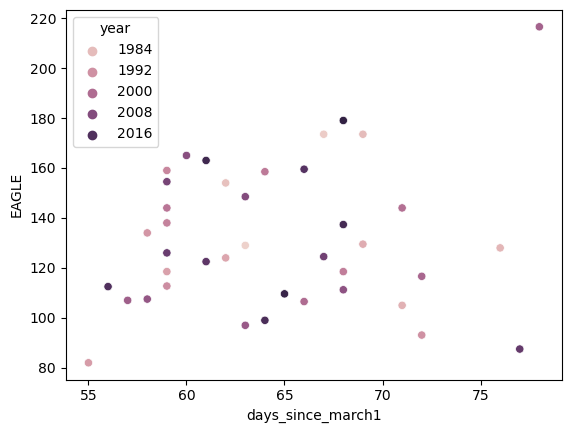

In [ ]:
sb.scatterplot(data=breakup, x='days_since_march1', y='EAGLE', hue='year')

<AxesSubplot: xlabel='days_since_march1', ylabel='AUKE_BAY'>

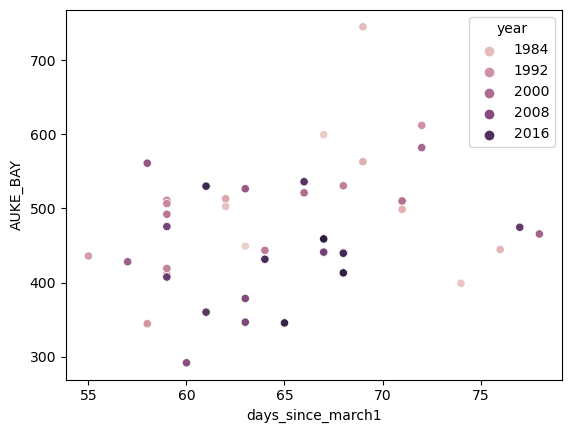

In [ ]:
sb.scatterplot(data=breakup, x='days_since_march1', y='AUKE_BAY', hue='year')

## Model breakup by TDD anomaly for all locations

Load breakup data again and recalculate anomaly dataframe.

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup_anomaly = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_tdd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
locations = breakup.siteID.unique()
locations

array(['Koyukuk River at Bettles', 'Kobuk River at Shungnak',
       'Buckland River at Buckland', 'Yukon River at Mountain Village',
       'Yukon River at Marshall', 'Yukon River at Russian Mission',
       'Yukon River at Holy Cross', 'Kobuk River at Ambler',
       'Yukon River at Anvik', 'Kobuk River at Kobuk',
       'Gulkana River nr Gakona', 'Yukon River at Alakanuk',
       'Yukon River nr Emmonak', 'Yukon River at Kaltag',
       'Yukon River at Galena', 'Yukon River at Fort Yukon',
       'Kuskokwim River at Tuluksak', 'Kuskokwim River at Kalskag',
       'Kuskokwim River at Crooked Creek', 'Kuskokwim River at Red Devil',
       'Kuskokwim River at Sleetmute', 'Kuskokwim River at Akiak',
       'Yukon River at Ruby', 'Kuskokwim River at McGrath',
       'Yentna River at Lake Creek', 'Yukon River at Tanana',
       'Koyukuk River at Hughes', 'Koyukuk River at Allakaket',
       'Yukon River at Circle', 'Susitna River at Sunshine',
       'Yukon River at Dawson', 'Yukon River 

In [ ]:
def calculate_corr(breakupDF=breakup_anomaly, show_plots=False, save_plots=False, 
               prefix="TDD_breakupday", locations=locations, stationnames=None):
    if not set(locations) <= set(breakupDF.siteID):
        raise Exception("Sorry, the location isn't available in the breakup dataset. Check spelling?")
    outputrecords = []
    for location in locations:
        testDF = breakupDF[breakupDF.siteID == location].sort_values(
            by='year').reset_index(drop=True)
        if stationnames is None:
            stationnames = testDF.columns[5:]
        if not set(stationnames) <= set(breakupDF.columns):
            raise Exception("Sorry, the station isn't a valid name")
        for stationname in stationnames:
            result = testDF[stationname].corr(testDF['days_since_march1'],
                        method=lambda x, y: pearsonr(x, y))
            outputrecords.append(
                {
                    "stationname": stationname,
                    "location": location,
                    "pvalue": result.pvalue,
                    "rvalue": result.statistic,
                    "r2value": result.statistic**2
                }
            )        
            if show_plots or save_plots:
                sb.regplot(data=testDF, y='days_since_march1', x=stationname, scatter=False)
                ax = sb.scatterplot(data=testDF, y='days_since_march1', x=stationname, 
                                    hue='year', palette="crest")
                ax.set_title(f"{stationname.replace('_', ' ').title()} station for {location} "
                             f"{prefix.replace('_', ' ')}")
                ax.set_xlabel("TDD anomaly")
                ax.set_ylabel("Days since March 1")
                plt.legend(loc='upper right')
                ax.text(0.06, 0.1, 
                        f'r = {result.statistic:.2f}\nr2 = {result.statistic**2:.2f}\np = {result.pvalue:.2E}', 
                        transform=ax.transAxes)
                if show_plots:
                    plt.show()
                if save_plots:
                    fn = f"{prefix}_{location.replace(' ', '_')}_AT_{stationname}.png"
                    plt.savefig(outpath / fn, bbox_inches='tight')
                    plt.close()
    return outputrecords
    

Make plots for all on breakup date

In [ ]:
calculate_corr(save_plots=True)

/Users/christine/miniconda3/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/christine/miniconda3/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


[{'stationname': 'ALYESKA',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.0003973362052727173,
  'rvalue': -0.5454872539375298,
  'r2value': 0.2975563442083072},
 {'stationname': 'ANCHORAGE_MERRILL_FIELD',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.018153157729233788,
  'rvalue': -0.4685606633250714,
  'r2value': 0.2195490952156309},
 {'stationname': 'ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.005441355759945149,
  'rvalue': -0.42636247776589065,
  'r2value': 0.18178496244666958},
 {'stationname': 'AUKE_BAY',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.050973849622185236,
  'rvalue': -0.31075675729625113,
  'r2value': 0.09656976220528113},
 {'stationname': 'BARROW_AIRPORT',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.049844780764884127,
  'rvalue': 0.3083293544408084,
  'r2value': 0.09506699080988565},
 {'stationname': 'BETHEL_AIRPORT',
  'location': 'Koyukuk River at Bettles',
  '

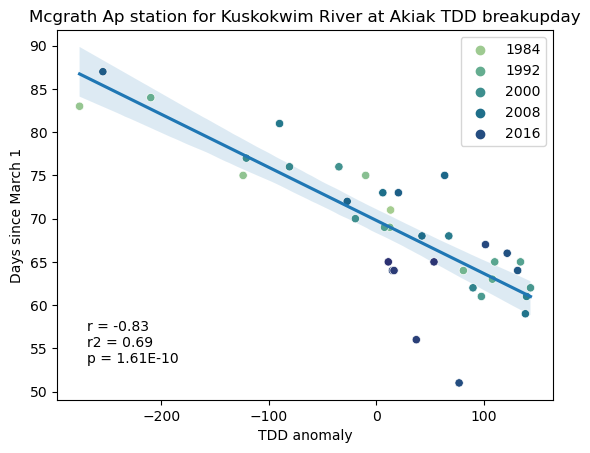

In [ ]:
returnrec = calculate_corr(locations=['Kuskokwim River at Akiak'], 
                           stationnames=['MCGRATH_AP'], show_plots=True)

In [ ]:
resultsDF_p = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2 = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / "breakupday_TDD_corr_pvalues.csv", "w") as dst:
    dst.write("# Correlations between TDD anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p.to_csv(dst)
with open(outpath / "breakupday_TDD_corr_r2values.csv", "w") as dst:
    dst.write("# Correlation R2 between TDD anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly on breakup date, and breakup date')

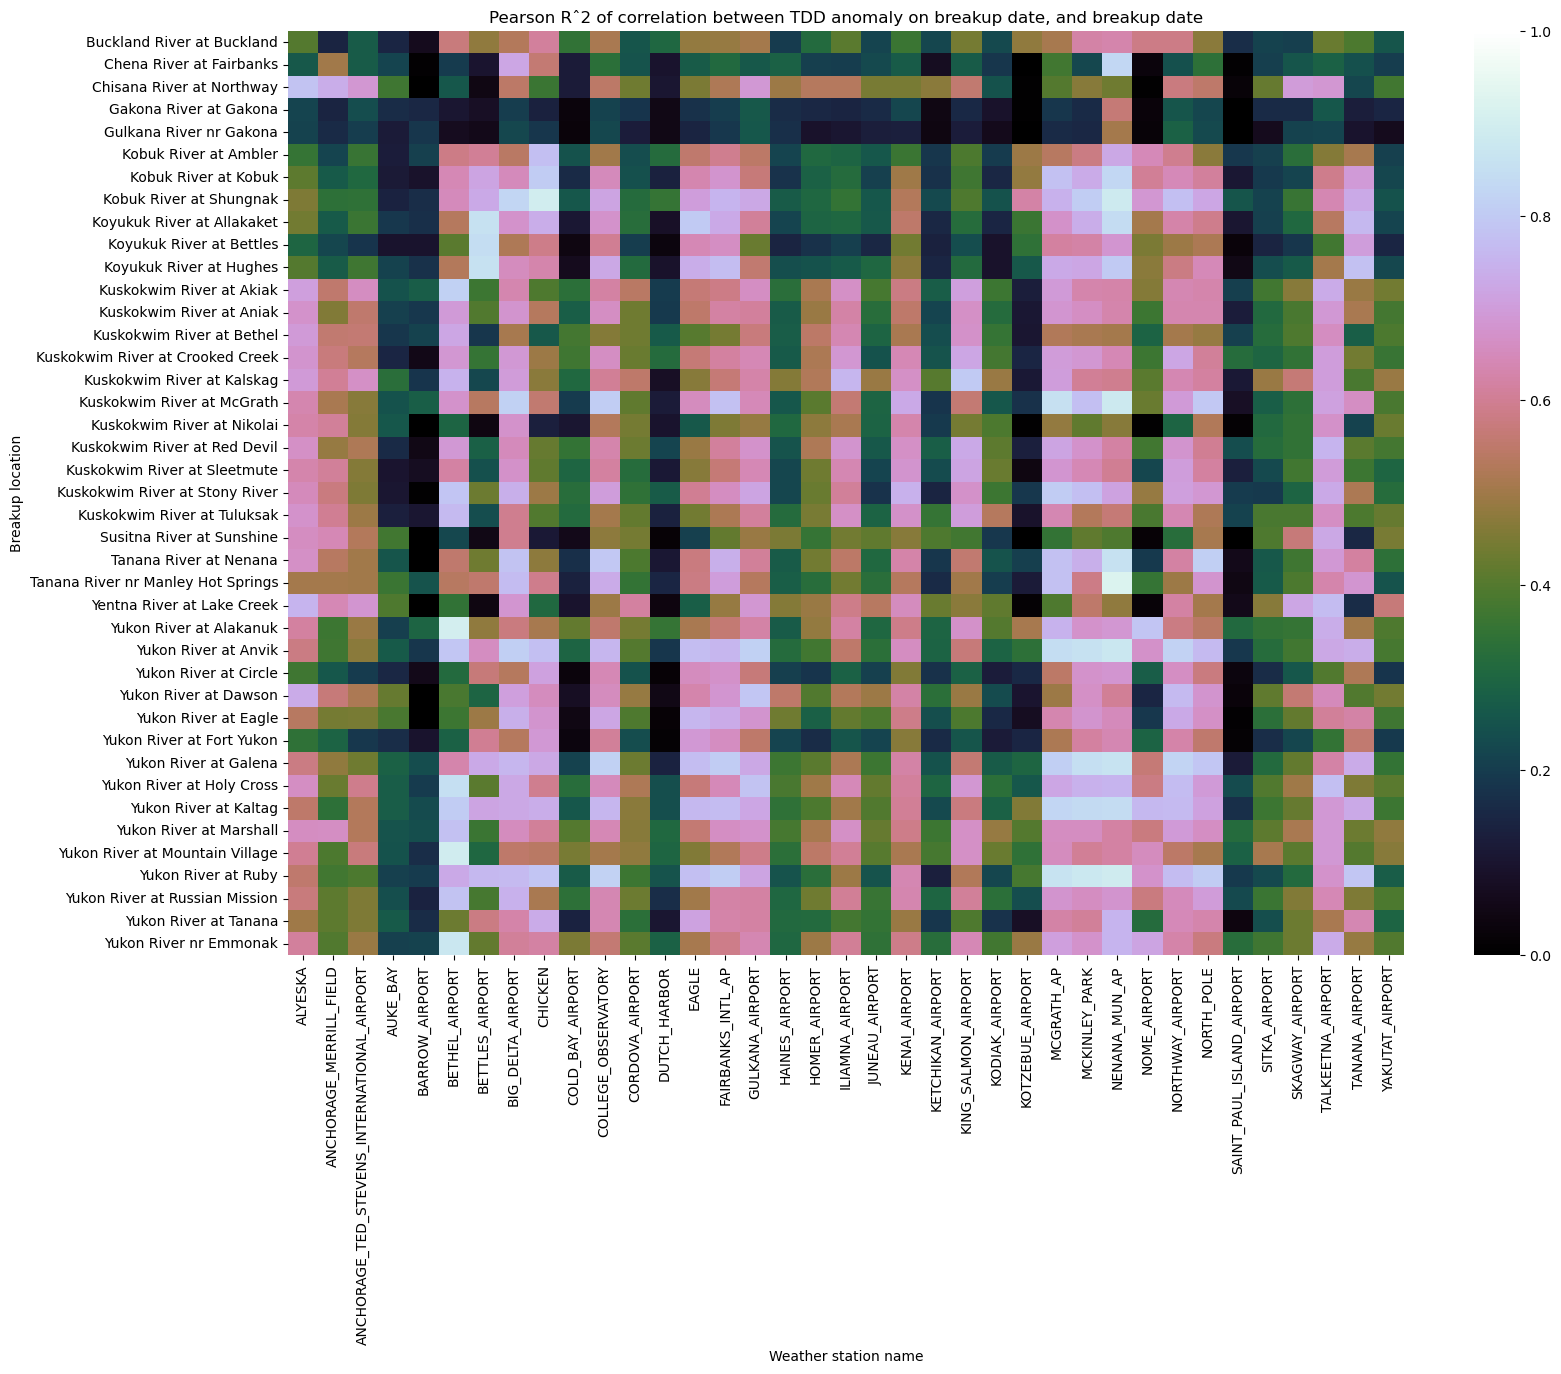

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Pearson Rˆ2 of correlation between TDD anomaly on breakup date, and breakup date")

Text(0.5, 1.0, 'Log10 of p-value of correlation between TDD anomaly and breakup date')

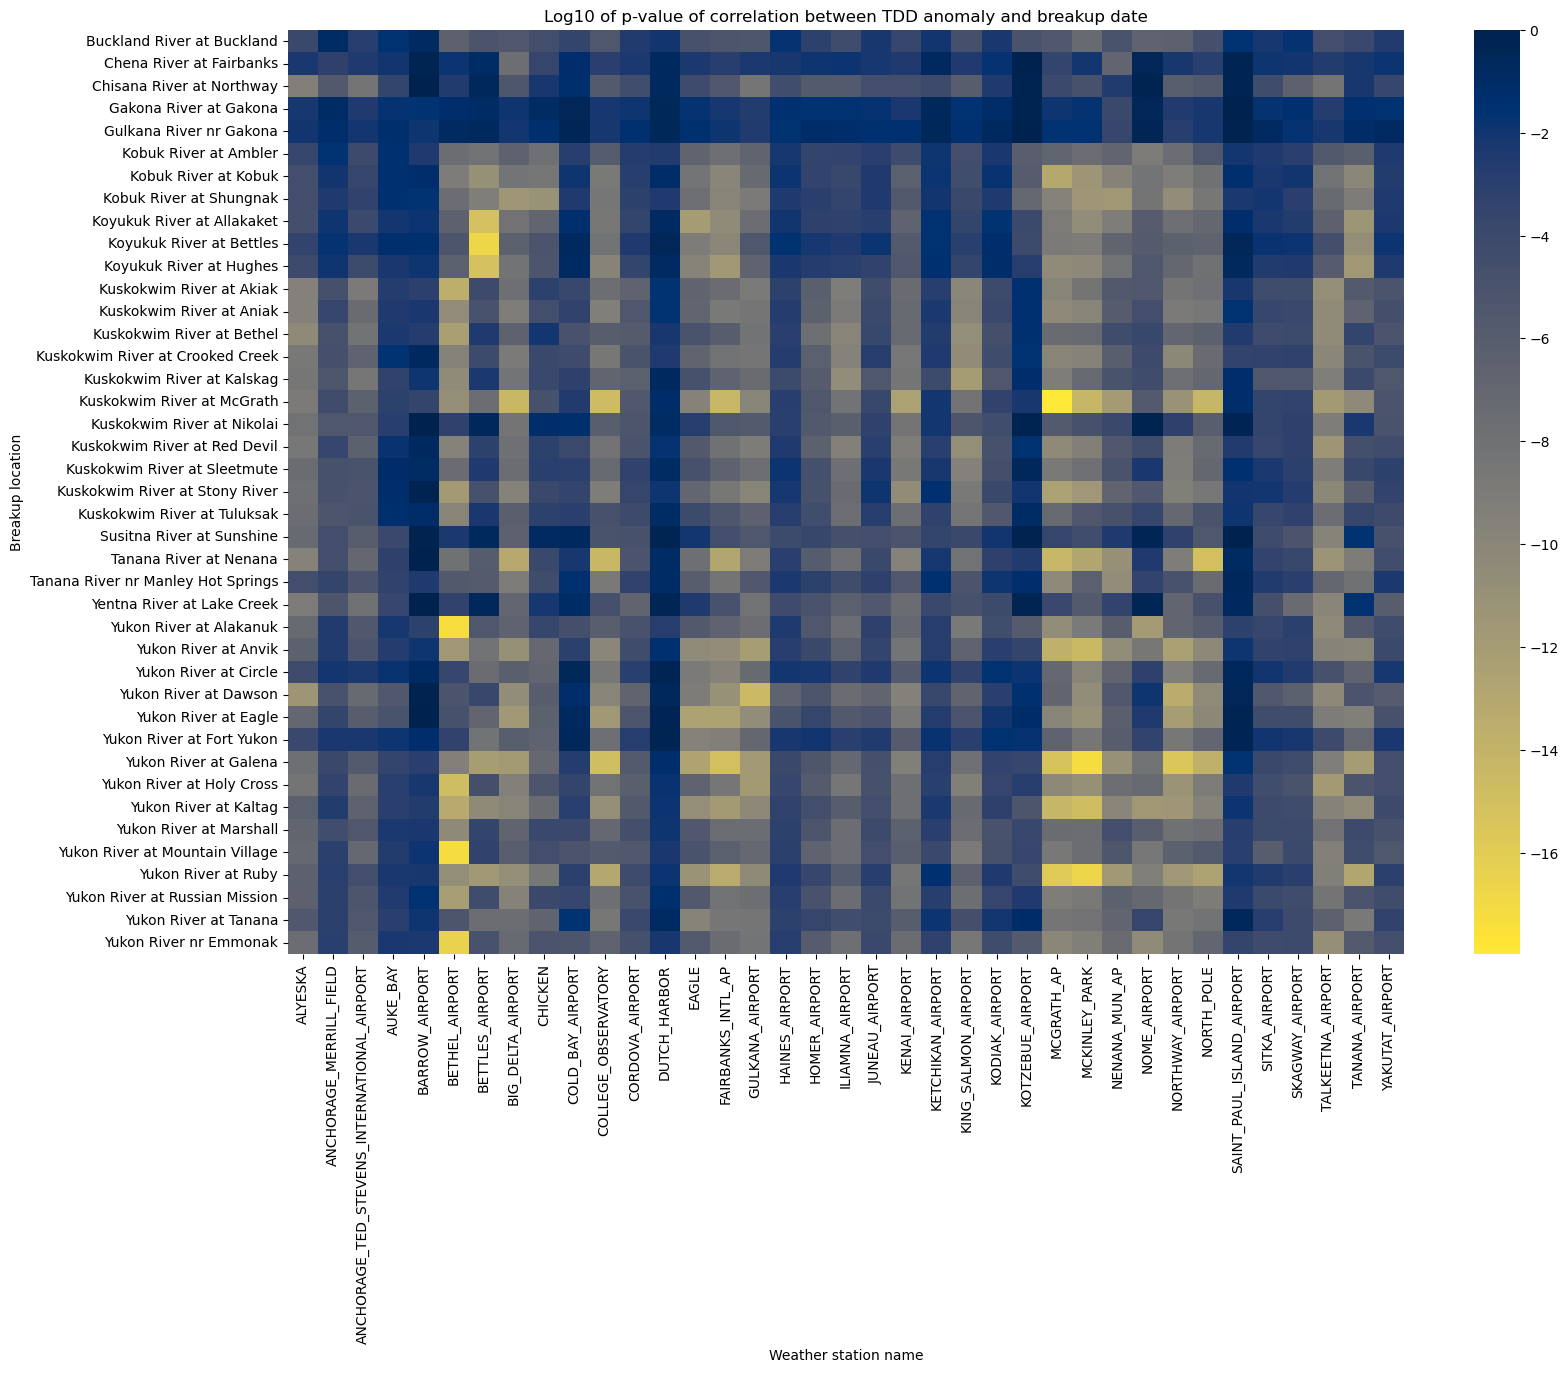

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    np.log10(resultsDF_p), 
    cmap='cividis_r', xticklabels=True, yticklabels=True)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Log10 of p-value of correlation between TDD anomaly and breakup date")

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops 

Top1  \
location                                                        
Buckland River at Buckland                     BARROW_AIRPORT   
Chena River at Fairbanks                     KOTZEBUE_AIRPORT   
Chisana River at Northway                      BARROW_AIRPORT   
Gakona River at Gakona              SAINT_PAUL_ISLAND_AIRPORT   
Gulkana River nr Gakona                      KOTZEBUE_AIRPORT   
Kobuk River at Ambler                                AUKE_BAY   
Kobuk River at Kobuk                           BARROW_AIRPORT   
Kobuk River at Shungnak                              AUKE_BAY   
Koyukuk River at Allakaket                       DUTCH_HARBOR   
Koyukuk River at Bettles            SAINT_PAUL_ISLAND_AIRPORT   
Koyukuk River at Hughes             SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at Akiak                     KOTZEBUE_AIRPORT   
Kuskokwim River at Aniak                     KOTZEBUE_AIRPORT   
Kuskokwim River at Bethel                    KOTZEBUE_AIRPORT   
Kuskokwim River at Crooked Creek               BARROW_AIRPORT   
Kuskokwim River at Kalskag                       DUTCH_HARBOR   
Kuskokwim River at McGrath          SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at Nikolai                     BARROW_AIRPORT   
Kuskokwim River at Red Devil                   BARROW_AIRPORT   
Kuskokwim River at Sleetmute                 KOTZEBUE_AIRPORT   
Kuskokwim River at Stony River                 BARROW_AIRPORT   
Kuskokwim River at Tuluksak                  KOTZEBUE_AIRPORT   
Susitna River at Sunshine           SAINT_PAUL_ISLAND_AIRPORT   
Tanana River at Nenana                         BARROW_AIRPORT   
Tanana River nr Manley Hot Springs  SAINT_PAUL_ISLAND_AIRPORT   
Yentna River at Lake Creek                     BARROW_AIRPORT   
Yukon River at Alakanuk                              AUKE_BAY   
Yukon River at Anvik                           BARROW_AIRPORT   
Yukon River at Circle                            DUTCH_HARBOR   
Yukon River at Dawson                          BARROW_AIRPORT   
Yukon River at Eagle                           BARROW_AIRPORT   
Yukon River at Fort Yukon                        DUTCH_HARBOR   
Yukon River at Galena               SAINT_PAUL_ISLAND_AIRPORT   
Yukon River at Holy Cross                      BARROW_AIRPORT   
Yukon River at Kaltag               SAINT_PAUL_ISLAND_AIRPORT   
Yukon River at Marshall                        BARROW_AIRPORT   
Yukon River at Mountain Village                BARROW_AIRPORT   
Yukon River at Ruby                         KETCHIKAN_AIRPORT   
Yukon River at Russian Mission                 BARROW_AIRPORT   
Yukon River at Tanana               SAINT_PAUL_ISLAND_AIRPORT   
Yukon River nr Emmonak                               AUKE_BAY   

                                                         Top2  \
location                                                        
Buckland River at Buckland            ANCHORAGE_MERRILL_FIELD   
Chena River at Fairbanks                       BARROW_AIRPORT   
Chisana River at Northway                        NOME_AIRPORT   
Gakona River at Gakona                       KOTZEBUE_AIRPORT   
Gulkana River nr Gakona             SAINT_PAUL_ISLAND_AIRPORT   
Kobuk River at Ambler                       KETCHIKAN_AIRPORT   
Kobuk River at Kobuk                SAINT_PAUL_ISLAND_AIRPORT   
Kobuk River at Shungnak                        BARROW_AIRPORT   
Koyukuk River at Allakaket          SAINT_PAUL_ISLAND_AIRPORT   
Koyukuk River at Bettles                         DUTCH_HARBOR   
Koyukuk River at Hughes                      COLD_BAY_AIRPORT   
Kuskokwim River at Akiak                         DUTCH_HARBOR   
Kuskokwim River at Aniak            SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at Bethel                     BETTLES_AIRPORT   
Kuskokwim River at Crooked Creek             KOTZEBUE_AIRPORT   
Kuskokwim River at Kalskag          SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at McGrath                       DUTCH_HARBOR   
Kuskokwim River at Nikolai

Now for 15 days before breakupm

In [ ]:
breakup_anomaly_offset = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_offset[stationname] = breakup_anomaly_offset.apply(
        lambda row: retrieve_tdd_anomaly(row, stationname, teststationDF, offset=10), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_offset)

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
resultsDF_p_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / "breakupdayminus15_TDD_corr_pvalues.csv", "w") as dst:
    dst.write("# Correlations between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_offset.to_csv(dst)
with open(outpath / "breakupdayminus15_TDD_corr_r2values.csv", "w") as dst:
    dst.write("# Correlation R2 between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_offset.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date')

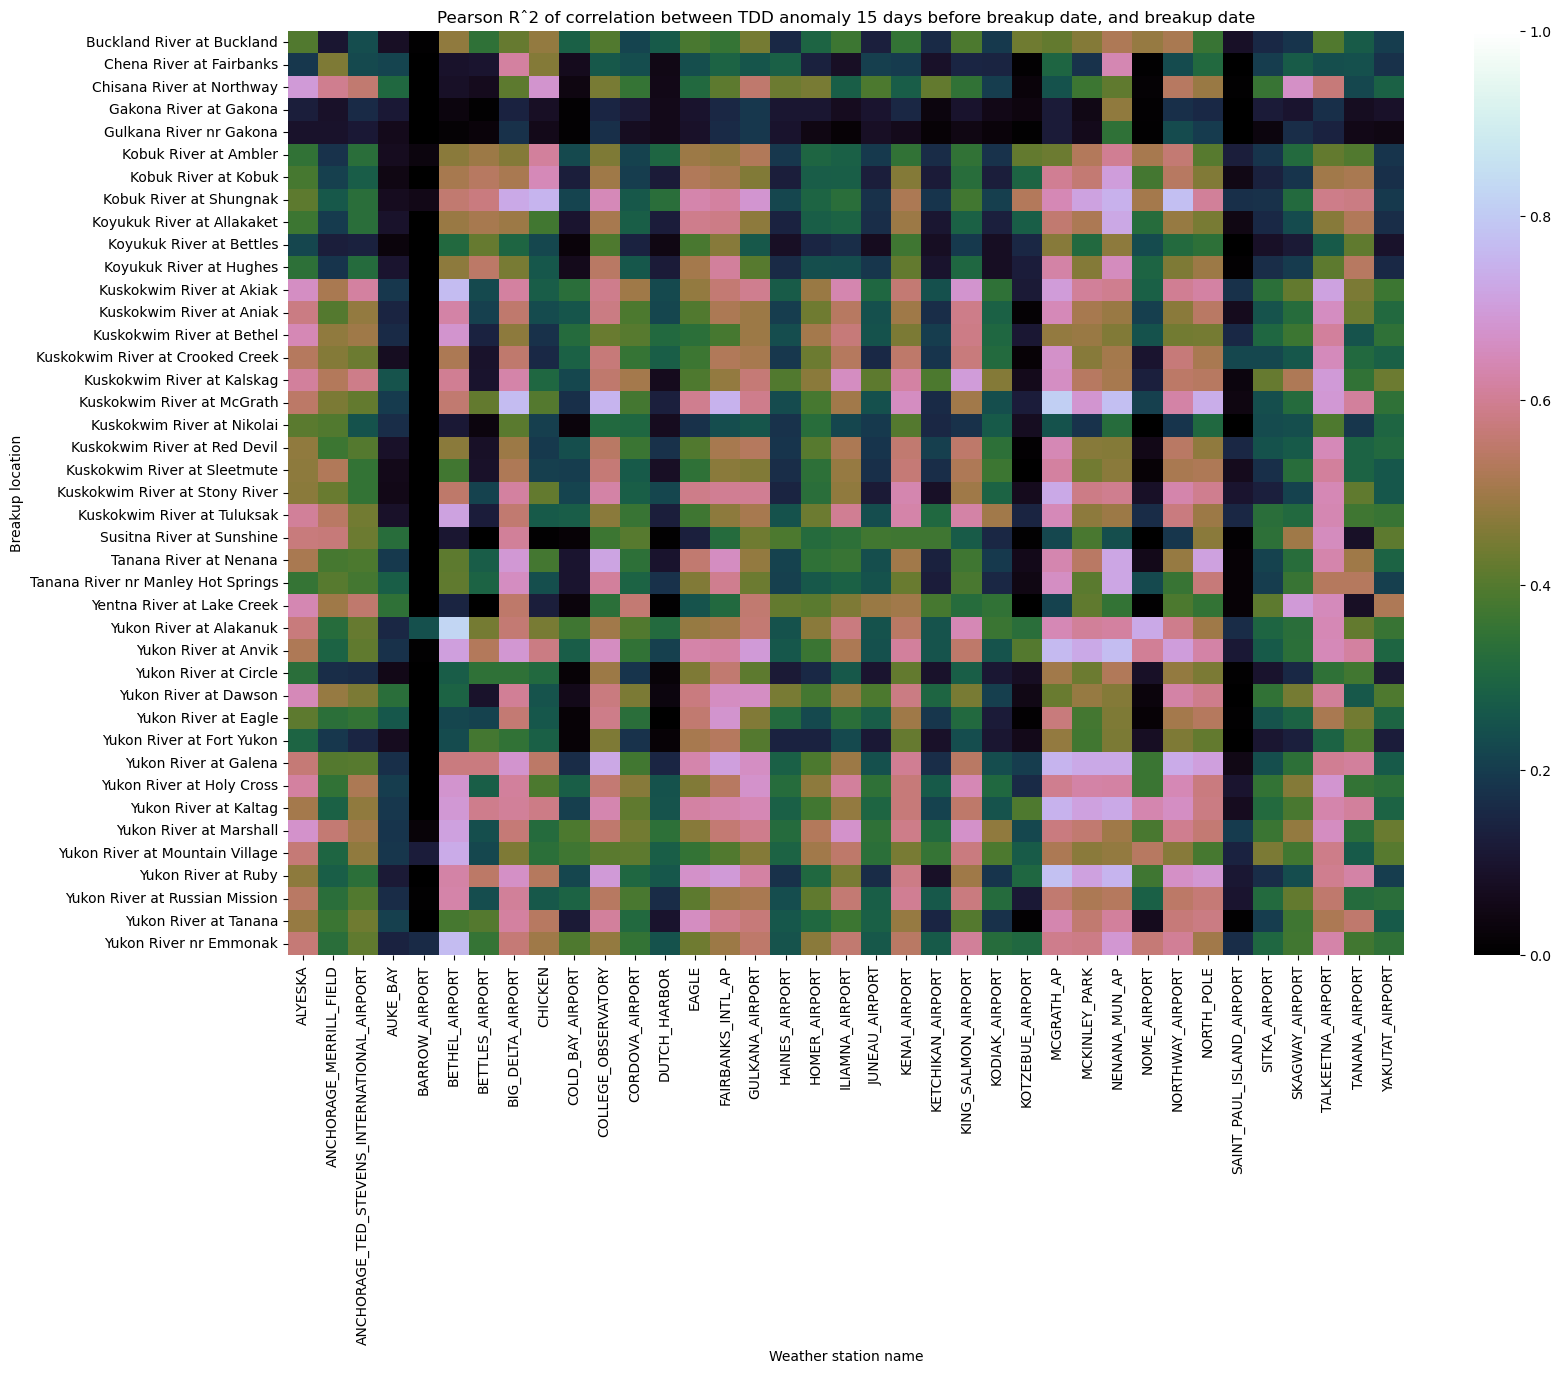

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_offset, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date")

Now for April 15th, or May 1, or whatever.

In [ ]:
datestr = "04-15"
textstr = "April 15"
fnstr = textstr.replace(" ", "")

In [ ]:
breakup_anomaly_fixed = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
        lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    # breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
    #     lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, "04-15"), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed)

In [ ]:
resultsDF_p_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / f"{fnstr}_TDD_corr_pvalues.csv", "w") as dst:
    dst.write(f"# Correlations between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_fixed.to_csv(dst)
with open(outpath / f"{fnstr}_TDD_corr_r2values.csv", "w") as dst:
    dst.write(f"# Correlation R2 between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_fixed.to_csv(dst)   
    

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly on April 15, and breakup date')

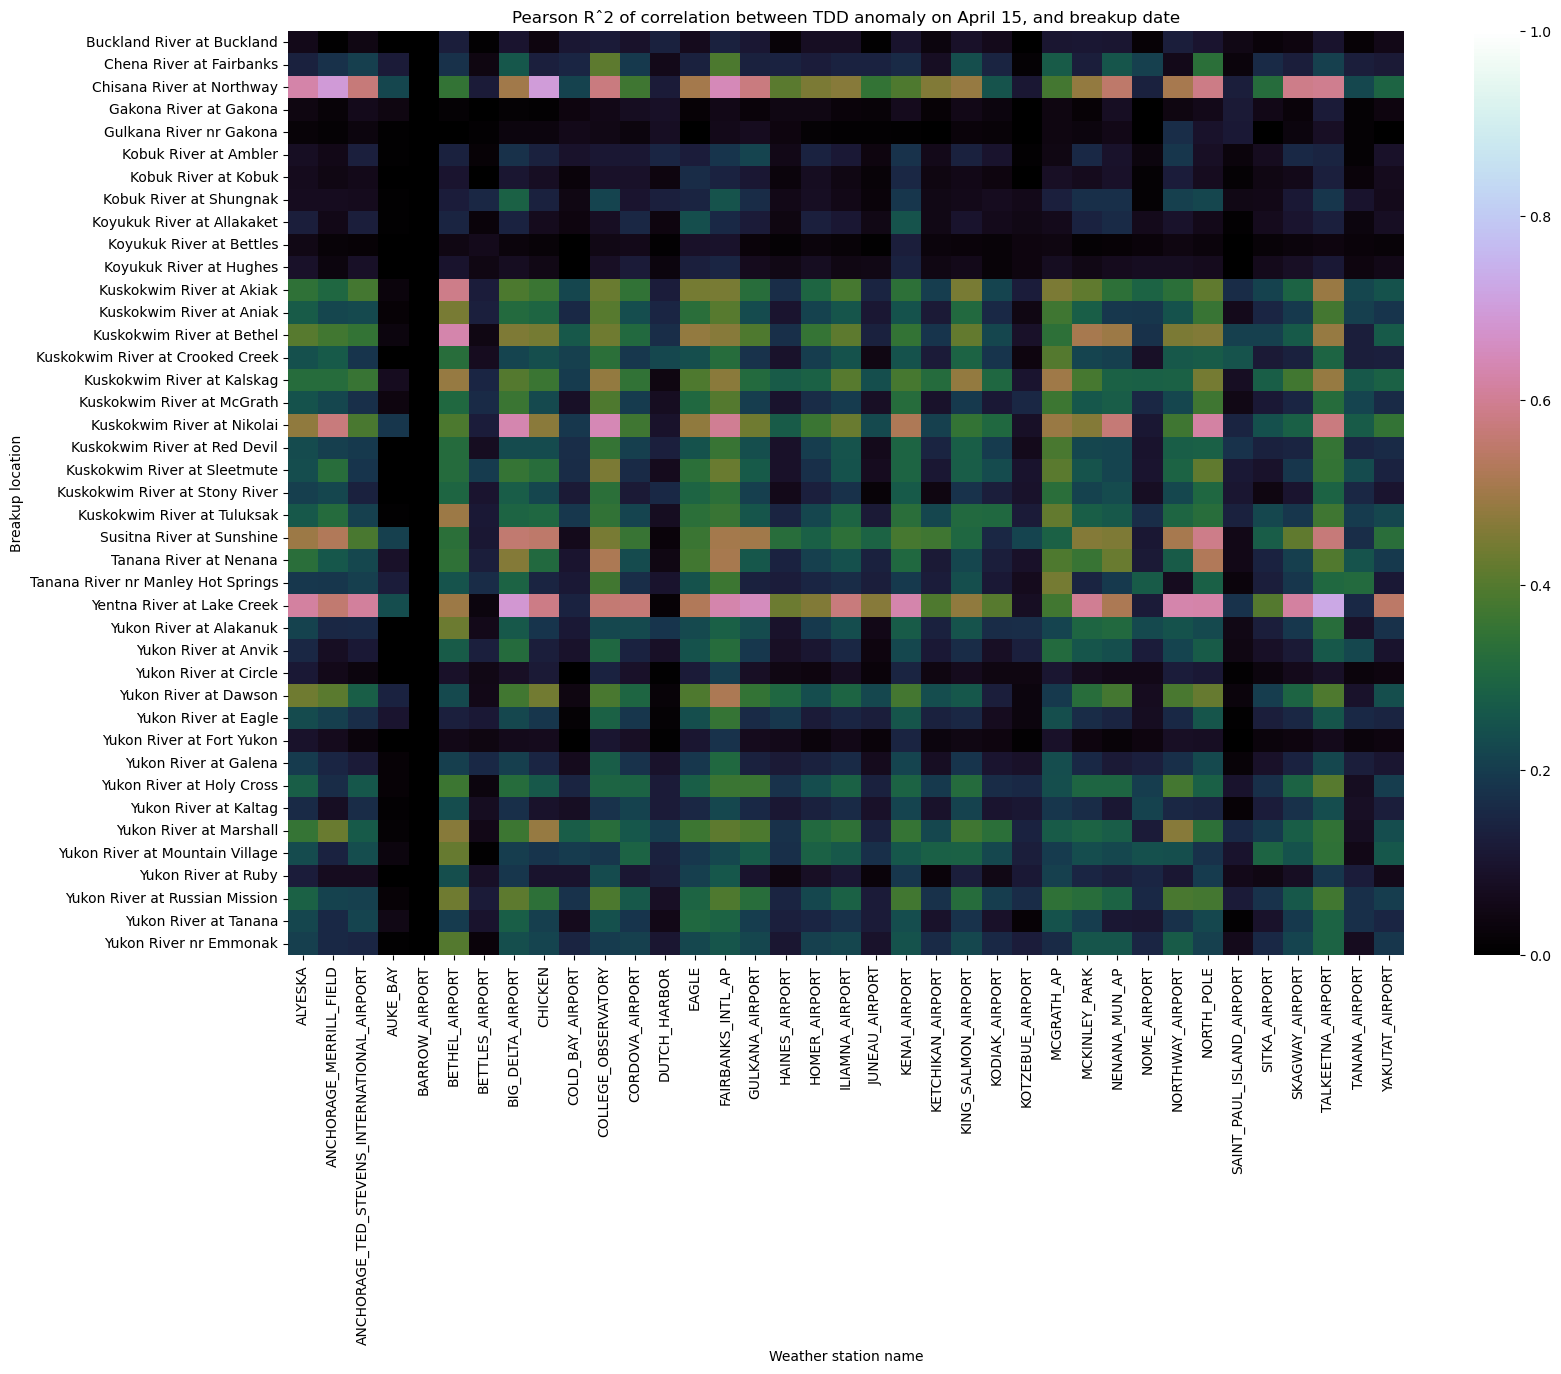

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_fixed, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title(f"Pearson Rˆ2 of correlation between TDD anomaly on {textstr}, and breakup date")

### Write top correlations to files

In [ ]:
results_r2_dict = resultsDF_r2.T.to_dict()
topstations_breakupday = {}
for location in results_r2_dict:
    topstations_breakupday[location] = dict(sorted(results_r2_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupday.json", "w") as dst:
    json.dump(topstations_breakupday, dst, indent=2)

In [ ]:
results_r2_offset_dict = resultsDF_r2_offset.T.to_dict()
topstations_breakupdayminus15 = {}
for location in results_r2_dict:
    topstations_breakupdayminus15[location] = dict(sorted(results_r2_offset_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupdayminus15.json", "w") as dst:
    json.dump(topstations_breakupdayminus15, dst, indent=2)

In [ ]:
results_r2_April25_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April25 = {}
for location in results_r2_April25_dict:
    topstations_April25[location] = dict(sorted(results_r2_April25_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April25.json", "w") as dst:
    json.dump(topstations_April25, dst, indent=2)

In [ ]:
results_r2_April15_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April15 = {}
for location in results_r2_April15_dict:
    topstations_April15[location] = dict(sorted(results_r2_April15_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April15.json", "w") as dst:
    json.dump(topstations_April15, dst, indent=2)

In [ ]:
import itertools

In [ ]:
maxN = 5
resultsdicts = {"breakupday": topstations_breakupday, 
                "breakupdayminus15": topstations_breakupdayminus15, 
                "April25": topstations_April25, 
                "April15": topstations_April15}

roundrobin = itertools.cycle(resultsdicts)

selectedstations = {}
locations = resultsdicts["breakupday"].keys()
for location in locations:
    print(f"Working on {location}")
    selectedstations[location] = set()
    ii = 0
    jj = 0
    for label in roundrobin:
        dict = resultsdicts[label]
        print(f"For {label}...")
        try:
            print(f"Retrieving element {ii}: {sorted(dict[location].items(), key=lambda x: -x[1])[ii][0]}")
            selectedstations[location].add(sorted(dict[location].items(), key=lambda x: -x[1])[ii][0])
        except IndexError:
            continue
        jj += 1
        ii = jj // 4 
        if len(selectedstations[location]) == maxN:
            selectedstations[location] = list(selectedstations[location])
            break


Working on Buckland River at Buckland
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 0: KOTZEBUE_AIRPORT
For April15...
Retrieving element 0: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: MCKINLEY_PARK
For breakupdayminus15...
Retrieving element 1: NORTHWAY_AIRPORT
Working on Chena River at Fairbanks
For April25...
Retrieving element 0: NENANA_MUN_AP
For April15...
Retrieving element 0: COLLEGE_OBSERVATORY
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 1: COLLEGE_OBSERVATORY
For April15...
Retrieving element 1: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: BIG_DELTA_AIRPORT
For breakupdayminus15...
Retrieving element 1: BIG_DELTA_AIRPORT
For April25...
Retrieving element 2: BIG_DELTA_AIRPORT
For April15...
Retrieving element 2: NORTH_POLE
Working on Chisana Rive

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops.to_json()

'{"Top1":{"Buckland River at Buckland":"BARROW_AIRPORT","Chena River at Fairbanks":"KOTZEBUE_AIRPORT","Chisana River at Northway":"BARROW_AIRPORT","Gakona River at Gakona":"SAINT_PAUL_ISLAND_AIRPORT","Gulkana River nr Gakona":"KOTZEBUE_AIRPORT","Kobuk River at Ambler":"AUKE_BAY","Kobuk River at Kobuk":"BARROW_AIRPORT","Kobuk River at Shungnak":"AUKE_BAY","Koyukuk River at Allakaket":"DUTCH_HARBOR","Koyukuk River at Bettles":"SAINT_PAUL_ISLAND_AIRPORT","Koyukuk River at Hughes":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Akiak":"KOTZEBUE_AIRPORT","Kuskokwim River at Aniak":"KOTZEBUE_AIRPORT","Kuskokwim River at Bethel":"KOTZEBUE_AIRPORT","Kuskokwim River at Crooked Creek":"BARROW_AIRPORT","Kuskokwim River at Kalskag":"DUTCH_HARBOR","Kuskokwim River at McGrath":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Nikolai":"BARROW_AIRPORT","Kuskokwim River at Red Devil":"BARROW_AIRPORT","Kuskokwim River at Sleetmute":"KOTZEBUE_AIRPORT","Kuskokwim River at Stony River":"BARROW_AIRPORT","Kus

In [ ]:
selectedstations

{'Buckland River at Buckland': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'MCKINLEY_PARK',
  'KOTZEBUE_AIRPORT'],
 'Chena River at Fairbanks': ['FAIRBANKS_INTL_AP',
  'NENANA_MUN_AP',
  'BIG_DELTA_AIRPORT',
  'NORTH_POLE',
  'COLLEGE_OBSERVATORY'],
 'Chisana River at Northway': ['SKAGWAY_AIRPORT',
  'ALYESKA',
  'CHICKEN',
  'ANCHORAGE_MERRILL_FIELD',
  'GULKANA_AIRPORT'],
 'Gakona River at Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'GULKANA_AIRPORT',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'TALKEETNA_AIRPORT'],
 'Gulkana River nr Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'GULKANA_AIRPORT',
  'NORTH_POLE'],
 'Kobuk River at Ambler': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'CHICKEN',
  'GULKANA_AIRPORT',
  'KOTZEBUE_AIRPORT'],
 'Kobuk River at Kobuk': ['NENANA_MUN_AP',
  'EAGLE',
  'KENAI_AIRPORT',
  'CHICKEN',
  'BIG_DELTA_AIRPORT'],
 'Kobuk River at Shungnak': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP'

In [ ]:
with open(outpath / "selectedstations.json", "w") as dst:
    json.dump(selectedstations, dst, indent=2)